# Import all the libraries and packages 

In [1]:
import os
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
import arviz as az
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal, norm

/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting Backend To: AvailableBackends.numpy


# Get the path of all the data

In [2]:
filename_a = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp131.pkl'
filename_b = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp133.pkl'
filename_c = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp136.pkl'

# Load and get the data

In [3]:
with open(filename_a, 'rb') as myfile:
    a= joblib.load(myfile)

# Description about Hyperspectral data
## Data is obtained by scannig the core data from different boreholes using hyperspectral sensors. There were around 450 channels for each pixels initially. It was preprocessed and seperated based on 10 different types of rocks. In each of the file we have "X", "Y", "Z" coordinates points corresponding to sensors and corresponding to each rock type we have a transformed RGB correspondence information. 

(235,)
(234,)


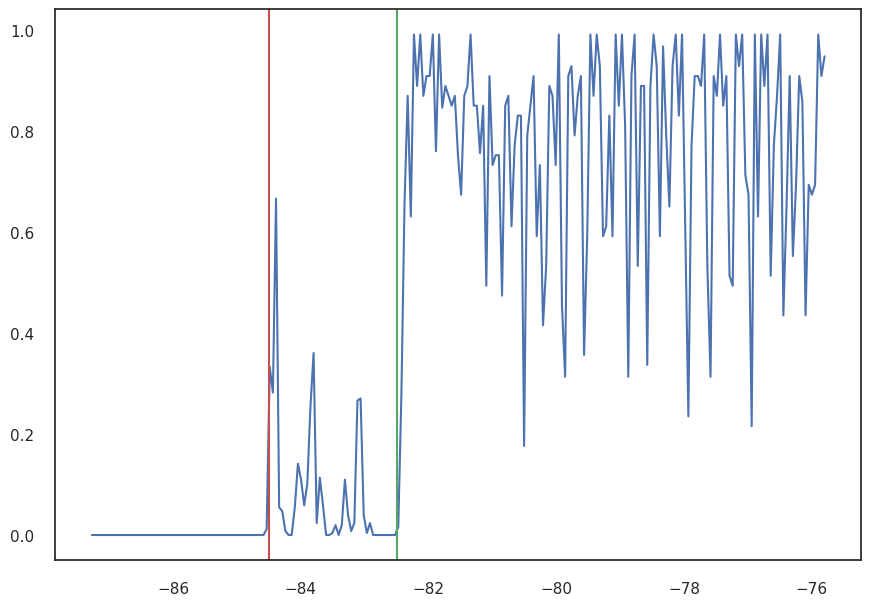

In [4]:
# The variability in "X" and "Y" are much smaller as compared to "Z" direction in case of birehole information. 
# Therefore, we are trying to build our model considering the "Z" direction mostly. 
# get the z-cordinates of borehole
zz = a['XYZ'][:,2]
print(zz.shape)
# sort the z-cordinates
ixx = np.argsort( zz )
# mask if values is less than some specified value
mask = zz[ixx] < -700
ah = a['BR_Anhydrite'][:,0] # correlates to "anhydrite index" derived from hyperspectral 
position_cord , hsi_data = zz[ixx][mask], ah[ixx][mask]/255 # To normalize the hyperspectral spectra, divide it with 255. 
plt.plot( position_cord/10 , hsi_data )
print(position_cord.shape)

# define breakpoints 
# In general it is very difficult to define the breakpoints in the plot. Prepocessing of hyperspectral data is itself a very difficult task
# becasue of high correaltion, high dimensional and noisy data. 
brk1 = -845/10 
brk2 = -825/10 

plt.axvline( brk1, color='r' )
plt.axvline( brk2, color='g')

In [5]:
hsi_data.reshape(1,-1)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01176471, 0.33333333, 0.28235294, 0.66666667,
        0.05490196, 0.04705882, 0.00784314, 0.        , 0.        ,
        0.05490196, 0.14117647, 0.10980392, 0.05882353, 0.10196078,
        0.25490196, 0.36078431, 0.02352941, 0.11

# Since it is difficult to classify a hyperspectral data in general. We can apply different classical clustering methods to have some starting guess

In [6]:

#gm = KMeans(n_clusters=3, random_state=42).fit(X)
#gm = GaussianMixture(n_components=3, random_state=0).fit(X)
gm = BayesianGaussianMixture(n_components=3, random_state=0).fit(hsi_data.reshape(-1,1))

In [7]:
gm.means_ , gm.covariances_

(array([[0.4912443 ],
        [0.01853378],
        [0.86780368]]),
 array([[[0.04165404]],
 
        [[0.00509574]],
 
        [[0.01363843]]]))

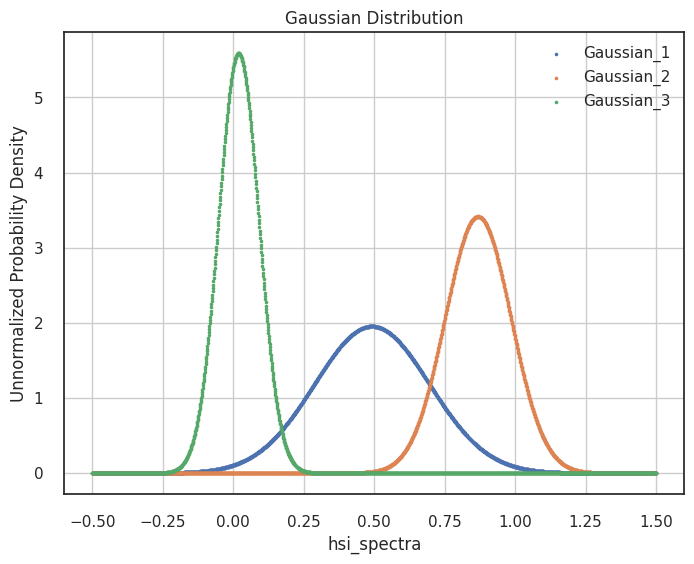

In [8]:

loc_mean_init, loc_var_init = gm.means_[[0,2,1]], np.sqrt(gm.covariances_[[0,2,1]])
# Create a grid of points
plt.figure(figsize=(8, 6))
x = np.linspace(-0.5,1.5,2000)
  # Combine x and y grids into a (100, 100, 2) array
for i in range(3):
    # Create a multivariate normal distribution
    rv = norm(loc_mean_init[i], loc_var_init[i])

    # Calculate PDF values for each point in the grid
    pdf_values = rv.pdf(x)

    # Plot the Gaussian distribution using contour plot
    
    plt.scatter(x, pdf_values, s=2.5, label='Gaussian_'+str(i+1))
#plt.colorbar(label='Probability Density')
plt.xlabel('hsi_spectra')
plt.ylabel('Unnormalized Probability Density')
plt.title('Gaussian Distribution')
#plt.scatter(loc_mean[i], color='red', label='Mean')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
y_gmm_label = gm.predict(hsi_data.reshape(-1,1))
print(y_gmm_label)
y_gmm_label_arranged = np.zeros_like(y_gmm_label)
y_gmm_label_arranged[y_gmm_label == 1] = 3
y_gmm_label_arranged[y_gmm_label == 0] = 2
y_gmm_label_arranged[y_gmm_label == 2] = 1
y_gmm_label_arranged = torch.Tensor(y_gmm_label_arranged)
y_gmm_label_arranged 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 0 2 2 2 1 2 2 2 0 2 0 0 2 2
 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 0 0 2 0 2 2 2 2 0 2 2 0 2 2 0 2 2 2 0 2 2 0
 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 0 2 0 2 2 2 0 2 2 2 0 0
 2 0 2 2 2 0 2 2 2 2 2 2]


tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 2., 2., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 1., 1., 2., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 3., 1., 1., 1., 2., 1.,
        2., 2., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1.,
        1., 2., 2., 1., 2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1.,
        1., 2., 1., 1., 2., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2.,
        1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1.,
        2., 1., 1., 1., 2., 2., 1., 2., 

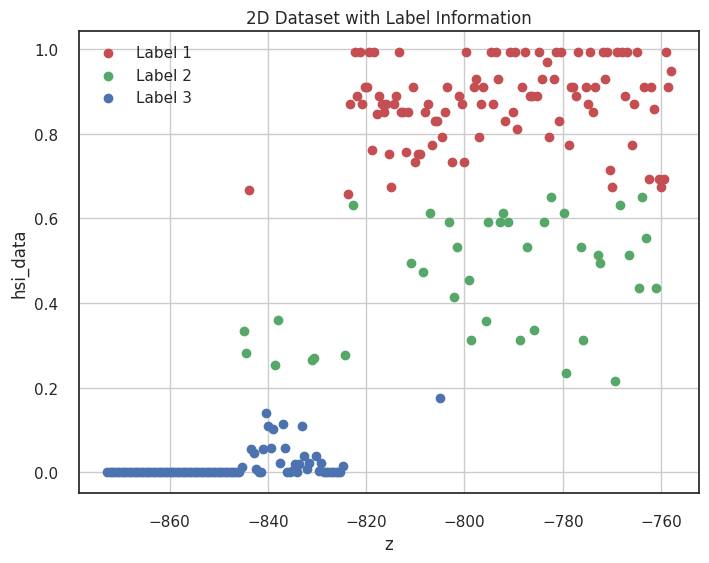

In [10]:
import matplotlib.pyplot as plt
# Define colors for each label
colors = ['r', 'g', 'b']
labels = y_gmm_label_arranged

# Plot the dataset with different colors for each label
plt.figure(figsize=(8, 6))
for label_val, color in zip([1,2,3], colors):
    plt.scatter(position_cord[labels == label_val], hsi_data[labels == label_val], c=color, label=f'Label {label_val}')

plt.xlabel('z')
plt.ylabel('hsi_data')
plt.title('2D Dataset with Label Information')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# A = np.zeros_like(a['BR_Anhydrite'][:, 0])
# B = np.zeros_like(a['BR_Anhydrite'][:, 0])
# C = np.zeros_like(a['BR_Anhydrite'][:, 0])

A = np.zeros_like(hsi_data)
B = np.zeros_like(hsi_data)
C = np.zeros_like(hsi_data)

# Get indices where the mask is True
# indices_A = np.where(mask & (zz[ixx] < brk1))
# indices_B = np.where(mask & (zz[ixx] > brk1) & (zz[ixx] < brk2))
# indices_C = np.where(mask & (zz[ixx] > brk2))
shift =0
# Get indices where the mask is True
indices_A = np.where(mask & (zz[ixx] < (brk1+shift)))
indices_B = np.where(mask & (zz[ixx] > (brk1+shift)) & (zz[ixx] < (brk2+shift)))
indices_C = np.where(mask & (zz[ixx] > (brk2+shift)))

y_obs_label = torch.ones(234)
y_obs_label[indices_A] =3
y_obs_label[indices_B] = 2
y_obs_label

tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 

In [12]:
matched_label = y_obs_label == y_gmm_label_arranged
(matched_label.sum()/len(y_obs_label)) *100

tensor(39.7436)

# We use the normalised hsi data y_obs_label information

In [13]:

y_obs_label = hsi_data.reshape((-1,1))
y_obs_label

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

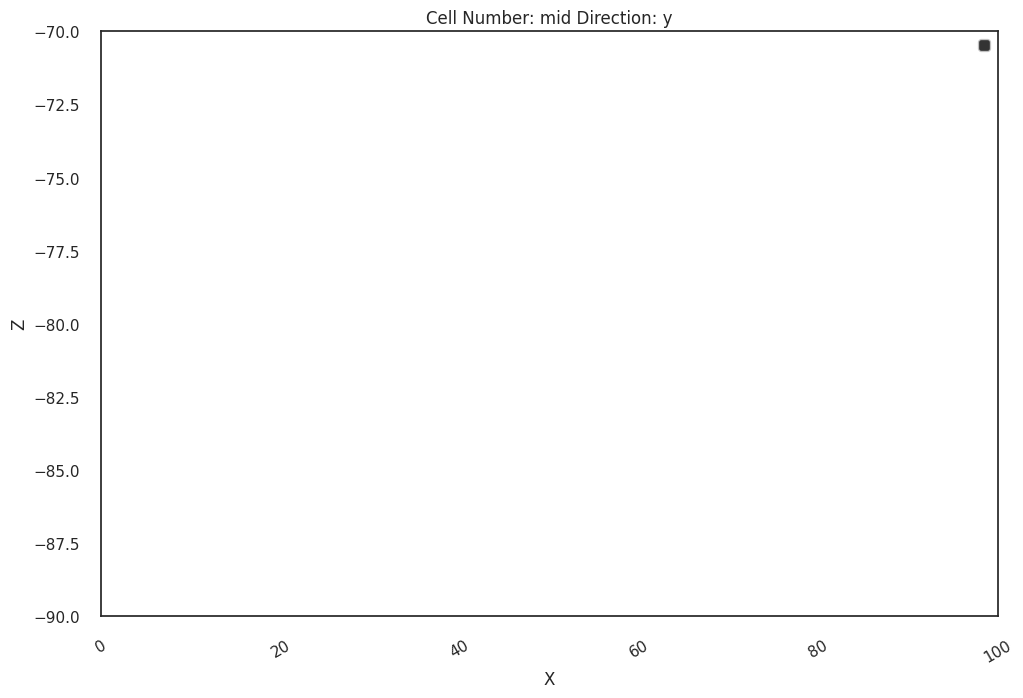

In [14]:
geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',
    extent=[0, 100, -50, 50, -90, -70],
    resolution=[100,100,100],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
p2d = gpv.plot_2d(geo_model_test)

In [15]:
geo_model_test.grid.active_grids_bool

array([False, False, False, False, False])

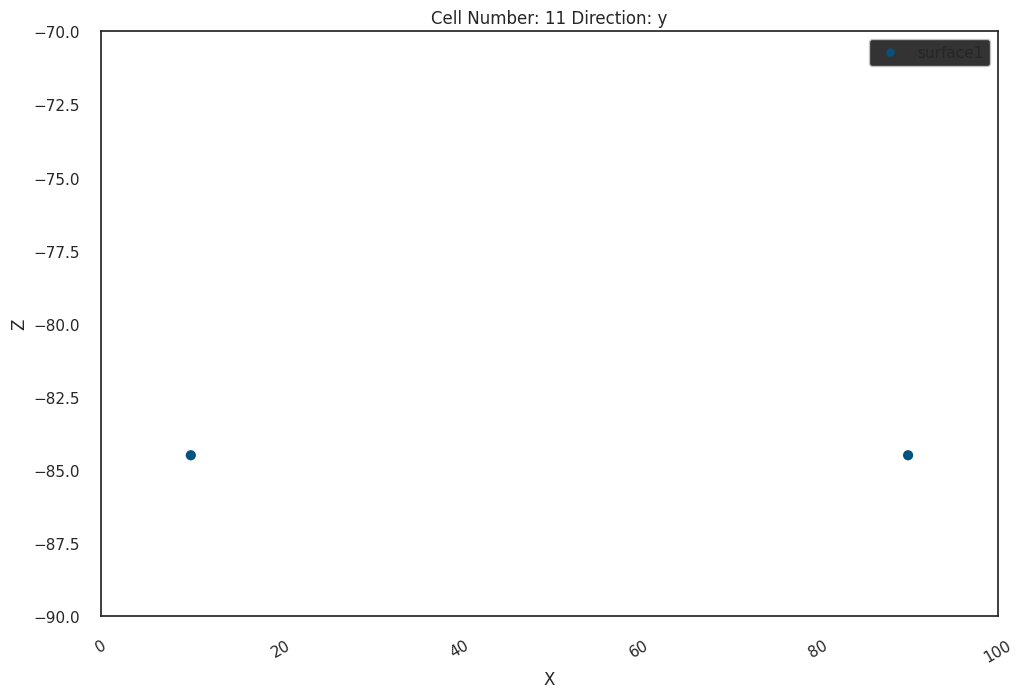

In [16]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[10.0, 90.0],
    y=[0.0, 0.0],
    z=[brk1, brk1],
    elements_names=['surface1', 'surface1']
)

gpv.plot_2d(geo_model_test, cell_number=11)

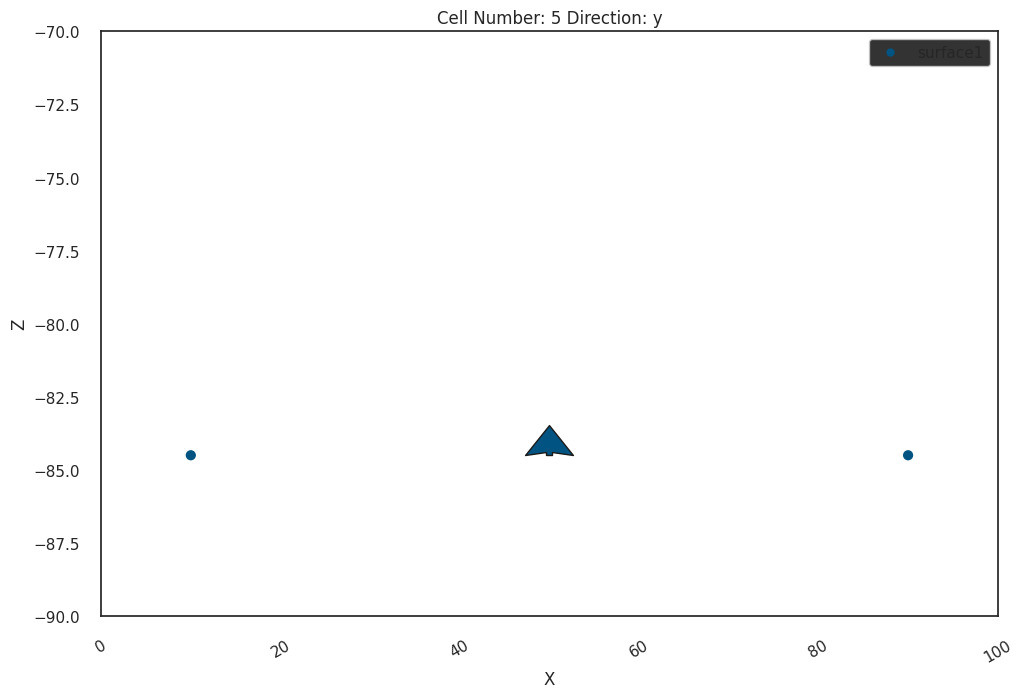

In [17]:
gp.add_orientations(
    geo_model=geo_model_test,
    x=[50],
    y=[0.0],
    z=[brk1],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1]]
)

gpv.plot_2d(geo_model_test, cell_number=5)

In [18]:
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

In [19]:
gp.compute_model(geo_model_test, engine_config=gp.data.GemPyEngineConfig())

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


Solutions(3 Octree Levels, 1 DualContouringMeshes)

In [20]:
geo_model_test.interpolation_options.kernel_options

KernelOptions(range=5, c_o=10, uni_degree=1, i_res=4, gi_res=2, number_dimensions=3, kernel_function=AvailableKernelFunctions.cubic, compute_condition_number=False, kernel_solver=Solvers.DEFAULT)

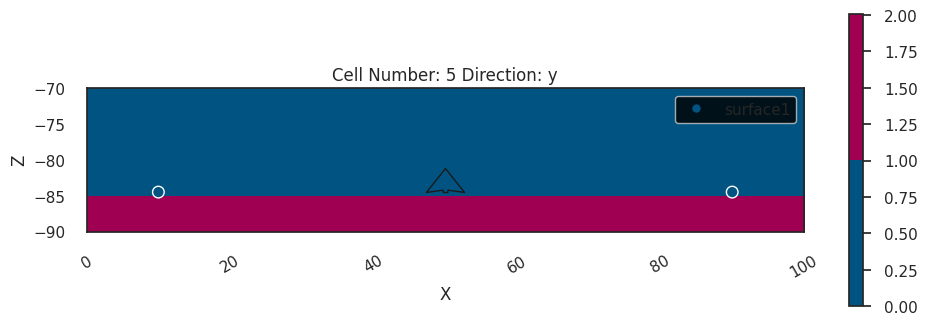

In [21]:
gpv.plot_2d(geo_model_test, cell_number=[5])

In [22]:
#gpv.plot_3d(geo_model_test, show_surfaces=True, image=True)

In [23]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

Setting Backend To: AvailableBackends.numpy


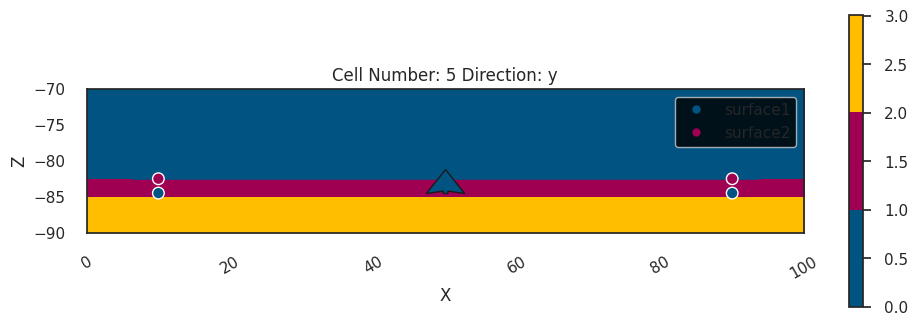

In [24]:
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([10.0, 90.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([brk2, brk2]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element2)
# Compute and visualize the updated model:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')
    

In [25]:
#gpv.plot_3d(geo_model_test, image=True)

In [26]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
),
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [27]:
geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1] = \
geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0]

In [28]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
),
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

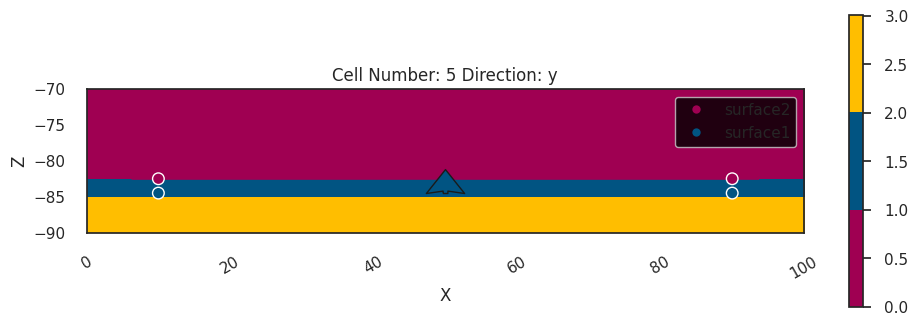

In [29]:
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

# Create a custome grid where the observed data information is available 

In [30]:
x_loc = 30
y_loc = 0
z_loc = position_cord
xyz_coord = np.array([[x_loc, y_loc, z] for z in z_loc])
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)

Active grids: ['custom']


In [31]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 10. ,   0. , -82.5],
       [ 90. ,   0. , -82.5],
       [ 10. ,   0. , -84.5],
       [ 90. ,   0. , -84.5]])

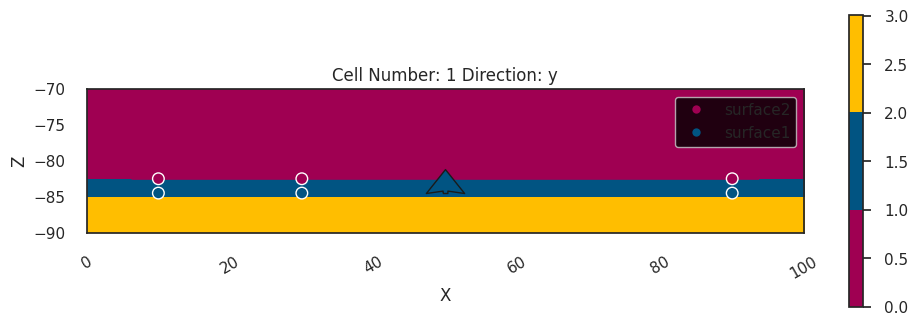

In [32]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[x_loc, x_loc],
    y=[0.0, 0.0],
    z=[brk1, brk2],
    elements_names=['surface1', 'surface2']
)
gpv.plot_2d(geo_model_test, cell_number=1)

In [33]:
geo_model_test.surface_points

X,Y,Z,id,nugget
10.00,0.00,-82.50,95431086,0.00
90.00,0.00,-82.50,95431086,0.00
30.00,0.00,-82.50,95431086,0.00
10.00,0.00,-84.50,48155407,0.00
90.00,0.00,-84.50,48155407,0.00
30.00,0.00,-84.50,48155407,0.00


Setting Backend To: AvailableBackends.numpy


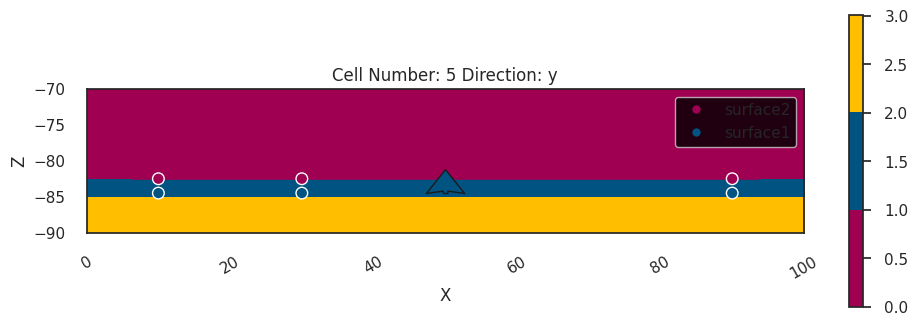

In [34]:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [35]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 10. ,   0. , -82.5],
       [ 90. ,   0. , -82.5],
       [ 30. ,   0. , -82.5],
       [ 10. ,   0. , -84.5],
       [ 90. ,   0. , -84.5],
       [ 30. ,   0. , -84.5]])

In [36]:
# Change the backend to PyTorch for probabilistic modeling
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)

Setting Backend To: AvailableBackends.PYTORCH


In [37]:
geo_model_test.interpolation_options.uni_degree = 0
geo_model_test.interpolation_options.mesh_extraction = False
geo_model_test.interpolation_options.sigmoid_slope = 1100.
geo_model_test.interpolation_options.kernel_options.range=5.0

In [38]:
#geo_model_test.solutions.octrees_output[0].last_output_center

In [39]:
custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values.shape

(234,)

In [40]:
y_obs_label.shape

(234, 1)

In [41]:
geo_model_test.surface_points

X,Y,Z,id,nugget
10.00,0.00,-82.50,95431086,0.00
90.00,0.00,-82.50,95431086,0.00
30.00,0.00,-82.50,95431086,0.00
10.00,0.00,-84.50,48155407,0.00
90.00,0.00,-84.50,48155407,0.00
30.00,0.00,-84.50,48155407,0.00


In [42]:
geo_model_test.orientations

X,Y,Z,G_x,G_y,G_z,id,nugget
50.00,0.00,-84.50,0.00,0.00,1.00,48155407,0.01


In [43]:
print(sp_coords_copy_test)
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

[[-0.25    0.      0.0125]
 [ 0.25    0.      0.0125]
 [-0.125   0.      0.0125]
 [-0.25    0.      0.    ]
 [ 0.25    0.      0.    ]
 [-0.125   0.      0.    ]]


array([[ 10. ,   0. , -82.5],
       [ 90. ,   0. , -82.5],
       [ 30. ,   0. , -82.5],
       [ 10. ,   0. , -84.5],
       [ 90. ,   0. , -84.5],
       [ 30. ,   0. , -84.5]])

Condition number: 54199.59343994383.
Condition number: 54199.59343994383.


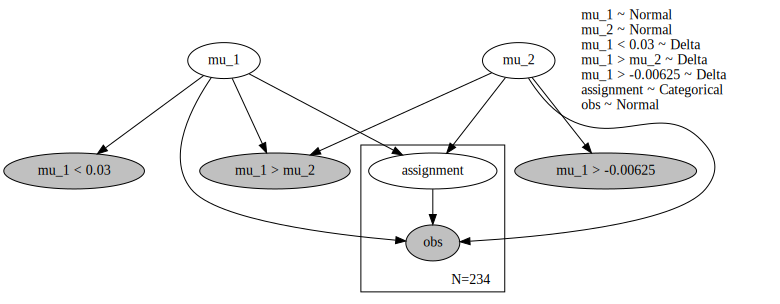

In [44]:
y_obs_label = torch.tensor(y_obs_label,dtype=torch.float64)


@config_enumerate
def model_test(obs_data):
    """
    This Pyro model represents the probabilistic aspects of the geological model.
    It defines a prior distribution for the top layer's location and
    computes the thickness of the geological layer as an observed variable.
    """
    # Define prior for the top layer's location
    prior_mean_surface_1 = sp_coords_copy_test[2, 2]
    prior_mean_surface_2 = sp_coords_copy_test[5, 2]
    
    

    
    mu_surface_1 = pyro.sample('mu_1', dist.Normal(prior_mean_surface_1, torch.tensor(0.00625, dtype=torch.float64)))
    mu_surface_2 = pyro.sample('mu_2', dist.Normal(prior_mean_surface_2, torch.tensor(0.00625, dtype=torch.float64)))
    
    # Ensure that mu_surface_1 is greater than mu_surface_2
    pyro.sample('mu_1 < 0.03', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 <0.03))
    pyro.sample('mu_1 > mu_2', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    pyro.sample('mu_1 > -0.00625', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_2 > -0.00625))
    # Update the model with the new top layer's location
    interpolation_input = geo_model_test.interpolation_input
    
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([2]), torch.tensor([2])),
        mu_surface_1
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        mu_surface_2
    )
    
    
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model_test.interpolation_options,
        data_descriptor=geo_model_test.input_data_descriptor,
        geophysics_input=geo_model_test.geophysics_input,
    )
    
    # Compute and observe the thickness of the geological layer
    
    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    
    lambda_ = 5
    #class_label = F.softmax(-lambda_* (torch.tensor([1,2,3], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    z_nk = F.softmax(-lambda_* (torch.tensor([1,2,3], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    N_k = torch.sum(z_nk,axis=0)
    N = len(custom_grid_values)
    pi_k = N_k /N
    mean = []
    cov = []
    #print("Z_nk",z_nk.shape)
    for i in range(z_nk.shape[1]):
            mean_k = torch.sum( z_nk[:,i][:,None] * obs_data, axis=0)/ N_k[i]
            #print("mean_k",mean_k.shape[0])
            #cov_k = torch.sum( (normalised_hsi - mean_k.reshape((-1,1))) (normalised_hsi - mean_k).T )
            cov_k = torch.tensor(0.0,dtype=torch.float64)
            for j in range(z_nk.shape[0]):
                 #cov_k +=  z_nk[j,i]* torch.matmul((obs_data[j,:] - mean_k).reshape((-1,1)) ,(obs_data[j,:] - mean_k).reshape((1,-1)))
                 cov_k +=  z_nk[j,i]* (obs_data[j,:] - mean_k)[0] * (obs_data[j,:] - mean_k)[0]
            mean.append(mean_k)
            cov_k=cov_k/N_k[i] #+ 1e-3 * torch.diag(torch.ones(cov_k.shape[0],dtype=torch.float64))
            cov.append(cov_k)
    mean_tensor = torch.stack(mean, dim=0).reshape(-1)
    cov_tensor = torch.stack(cov,dim=0)
    #print(mean_tensor.shape, cov_tensor.shape, obs_data.shape)
    with pyro.plate('N='+str(y_obs_label.shape[0]), y_obs_label.shape[0]):
        assignment = pyro.sample("assignment", dist.Categorical(pi_k))
        #print(mean_tensor[assignment].shape, cov_tensor[assignment].shape)
        obs = pyro.sample("obs", dist.Normal(mean_tensor[assignment], torch.sqrt(cov_tensor[assignment]) ), obs=obs_data.reshape(-1))
    #return obs
dependencies = get_dependencies(model_test, model_args=(y_obs_label,))
pyro.render_model(model_test, model_args=(y_obs_label,),render_distributions=True)

In [45]:
print(y_obs_label.shape)
# model_test(y_obs_label)

torch.Size([234, 1])


Condition number: 54199.59343994383.
Condition number: 54562.34676822463.
Condition number: 31478.089137671257.
Condition number: 47664.37907693985.
Condition number: 49249.51805619393.
Condition number: 48205.19387975426.
Condition number: 51250.9573384815.
Condition number: 39477.187984398064.
Condition number: 48165.00287610555.
Condition number: 45632.12147873771.
Condition number: 48189.62650944085.
Condition number: 54202.69932434632.
Condition number: 42284.81114792912.
Condition number: 51243.562149670135.
Condition number: 38944.34186793791.
Condition number: 46281.11937730642.
Condition number: 40786.51991412153.
Condition number: 52867.13059941565.
Condition number: 32939.3628560763.
Condition number: 54353.59850319554.
Condition number: 48250.505795724086.
Condition number: 43267.82214984582.
Condition number: 44620.24143964181.
Condition number: 54492.556844482715.
Condition number: 35574.549205810625.
Condition number: 53035.548485634514.
Condition number: 40577.167407432

/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


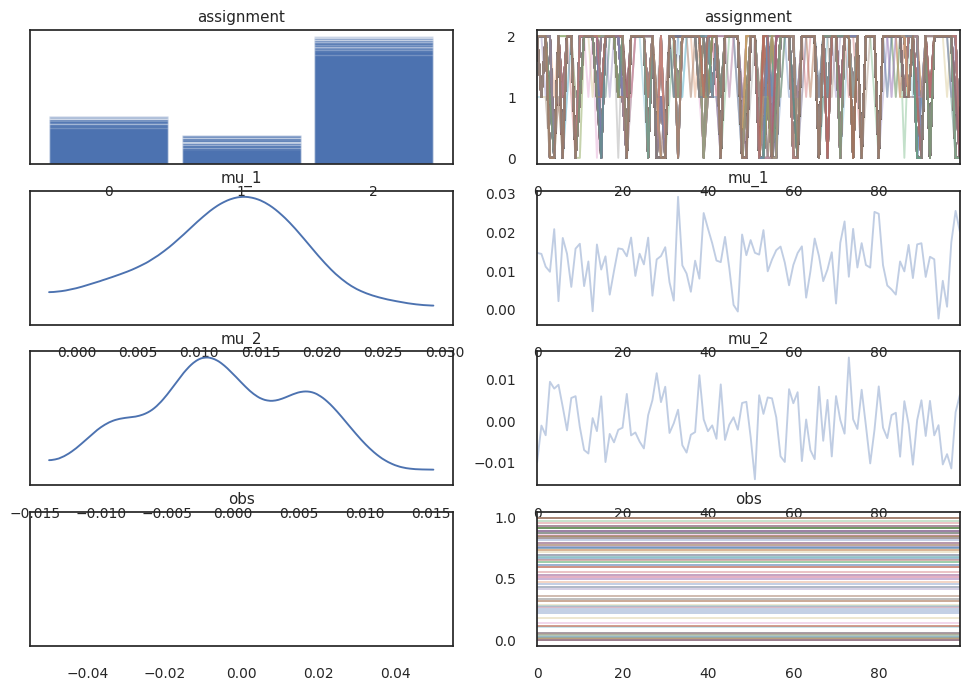

In [46]:
prior = Predictive(model_test, num_samples=100)(y_obs_label)

# Key to avoid
avoid_key = ['mu_1 > mu_2','mu_1 < 0.03','mu_1 > -0.00625']

# Create sub-dictionary without the avoid_key
prior = dict((key, value) for key, value in prior.items() if key not in avoid_key)

data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()

In [47]:
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
#nuts_kernel = NUTS(model_test, step_size=0.00085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10)
#nuts_kernel = NUTS(model_test)
initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
#mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False, initial_params=initial_values)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50, disable_validation=False)
mcmc.run(y_obs_label)

Warmup:   0%|          | 0/150 [00:00, ?it/s]

Condition number: 54556.09193279519.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 187099.23178466276.
Condition number: 52007.342764725225.
Condition number: 43531.987170309694.
Condition number: 52007.342764725225.
Condition number: 53315.85616088957.
Condition number: 52007.342764725225.
Condition number: 50916.86847413478.
Condition number: 52007.342764725225.
Condition number: 51017.01529048742.
Condition number: 52007.342764725225.
Condition number: 52656.13622975691.
Condition number: 52007.342764725225.
Condition number: 52298.1174321162.
Condition number: 52007.342764725225.
Condition number: 52012.525545835204.


Warmup:   1%|          | 1/150 [00:01,  1.23s/it, step size=5.84e-04, acc. prob=0.829]

Condition number: 52086.063571220024.
Condition number: 51960.49995266225.
Condition number: 51925.38519173386.
Condition number: 52140.49253744902.
Condition number: 52628.65432954676.


Warmup:   1%|▏         | 2/150 [00:01,  1.54it/s, step size=6.74e-05, acc. prob=0.415]

Condition number: 41497.88284449652.
Condition number: 46521.085183810465.
Condition number: 30048.82835667393.
Condition number: 21931.128828734472.
Condition number: 52105.83405123956.
Condition number: 51824.5156430698.
Condition number: 51679.56306815654.
Condition number: 51514.57051483268.
Condition number: 51355.07210638329.
Condition number: 51210.48708063882.
Condition number: 51047.90658725724.
Condition number: 50861.85563716559.
Condition number: 50692.33245772104.
Condition number: 50540.81619930353.
Condition number: 50360.62000435865.
Condition number: 50154.10539065365.
Condition number: 49975.82658970846.
Condition number: 49820.239185045764.
Condition number: 49625.91091903734.
Condition number: 52248.9337019379.
Condition number: 52378.333110143954.
Condition number: 52504.09655939353.
Condition number: 52631.01429704157.
Condition number: 52753.05520394817.
Condition number: 52869.0555181303.
Condition number: 52981.20090369146.
Condition number: 53088.1974506917.
C

Warmup:   2%|▏         | 3/150 [00:07,  2.96s/it, step size=6.48e-05, acc. prob=0.609]

Condition number: 33744.33288100328.
Condition number: 33851.507591713584.
Condition number: 33782.727364959355.
Condition number: 34236.171889824545.
Condition number: 34273.80883582055.
Condition number: 34436.33049332485.
Condition number: 34560.083276801124.
Condition number: 34534.74741478073.
Condition number: 34429.989072914024.
Condition number: 34420.442713368044.
Condition number: 34409.28902649258.
Condition number: 34338.26408539801.


Warmup:   3%|▎         | 5/150 [00:07,  1.30s/it, step size=3.38e-05, acc. prob=0.700]

Condition number: 34172.63646296793.
Condition number: 34089.873135803246.
Condition number: 34221.770258019766.
Condition number: 34265.503210434945.
Condition number: 34511.00753038514.
Condition number: 34282.90101307823.


Warmup:   4%|▍         | 6/150 [00:07,  1.12it/s, step size=4.23e-05, acc. prob=0.750]

Condition number: 34323.855884182194.
Condition number: 34445.773968538364.
Condition number: 34445.30869209392.
Condition number: 34494.03252001166.
Condition number: 34587.62876946972.
Condition number: 34470.720510444145.
Condition number: 34485.69126079954.
Condition number: 34459.858974069655.
Condition number: 34385.33139573705.
Condition number: 34700.87651311901.
Condition number: 34797.19215486542.
Condition number: 34850.016578946226.
Condition number: 34856.28572437864.
Condition number: 34837.45226002411.
Condition number: 34829.33254768591.
Condition number: 34861.48999916263.
Condition number: 34942.54147541087.
Condition number: 35056.65761585448.
Condition number: 35170.573866472456.
Condition number: 35251.3072142857.
Condition number: 35284.60925432029.
Condition number: 35280.773209107436.
Condition number: 35270.450742918074.
Condition number: 35287.91929331393.
Condition number: 35352.453848613724.
Condition number: 35459.84653605341.
Condition number: 35584.270212

Warmup:   5%|▍         | 7/150 [00:20,  4.84s/it, step size=5.47e-05, acc. prob=0.785]

Condition number: 53800.51050858198.
Condition number: 53815.5421429605.
Condition number: 53831.46668735597.
Condition number: 53767.64312578102.
Condition number: 53750.06871672942.
Condition number: 53733.37612647688.
Condition number: 53716.701294734616.
Condition number: 53847.69488928556.
Condition number: 53862.52715925798.
Condition number: 53876.157727342026.
Condition number: 53890.37399511918.
Condition number: 53905.417143020146.
Condition number: 53919.53663592419.
Condition number: 53932.06673881932.
Condition number: 53944.64180602963.
Condition number: 53958.31623498403.
Condition number: 53971.70285928869.
Condition number: 53983.399645412384.
Condition number: 53994.50871566887.
Condition number: 54006.69626812562.
Condition number: 54019.24062015568.
Condition number: 54030.28910549386.
Condition number: 54040.17767124096.
Condition number: 54050.8531785996.
Condition number: 54062.40255530555.
Condition number: 54072.89100056272.
Condition number: 54081.824833775216

Warmup:   5%|▌         | 8/150 [00:24,  4.54s/it, step size=7.30e-05, acc. prob=0.812]

Condition number: 54308.78375962504.
Condition number: 54310.73590819028.
Condition number: 54313.9761470609.
Condition number: 53614.23546414046.
Condition number: 53670.000318531376.
Condition number: 53697.14371752446.
Condition number: 53585.15979879045.
Condition number: 53556.050901916475.
Condition number: 53525.18642484231.
Condition number: 53494.08837979538.
Condition number: 53462.78574625575.
Condition number: 53429.84128461992.
Condition number: 53396.641957321925.
Condition number: 53363.10856158917.
Condition number: 53328.07035183519.
Condition number: 53292.70678551122.
Condition number: 53256.914530896756.
Condition number: 53219.77245711543.
Condition number: 53182.20133822752.
Condition number: 53144.1273942385.
Condition number: 53104.87692475792.
Condition number: 53065.078013686674.
Condition number: 53024.70272841155.
Condition number: 52983.3447580928.
Condition number: 52941.32444508609.
Condition number: 52898.63156102792.
Condition number: 52855.16931638622.

Warmup:   6%|▌         | 9/150 [00:32,  5.70s/it, step size=9.91e-05, acc. prob=0.833]

Condition number: 45222.05241074697.
Condition number: 50174.81699909309.
Condition number: 50037.804229106834.
Condition number: 50337.13219464404.
Condition number: 50606.77710133359.
Condition number: 50686.523015845945.


Warmup:   7%|▋         | 11/150 [00:33,  3.08s/it, step size=7.22e-06, acc. prob=0.770]

Condition number: 50824.718259466055.
Condition number: 51060.61709791148.
Condition number: 51127.512089507894.
Condition number: 50186.21345168771.
Condition number: 50197.72265014358.
Condition number: 50209.334343414776.
Condition number: 50221.035688109725.
Condition number: 50232.81156048229.
Condition number: 50244.644911037234.
Condition number: 50256.51717233266.
Condition number: 50163.54071225524.
Condition number: 50152.38899639108.
Condition number: 50141.3631233629.
Condition number: 50130.461181985.
Condition number: 50119.67809191591.
Condition number: 50109.00568648159.
Condition number: 50098.43287279401.
Condition number: 50087.94584777294.
Condition number: 50077.5283876733.
Condition number: 50067.16221236698.
Condition number: 50056.8274016821.
Condition number: 50046.502850312165.
Condition number: 50036.166798587044.
Condition number: 50025.79736439961.
Condition number: 50015.37309563299.
Condition number: 50004.873515130435.
Condition number: 49994.279641966.


Warmup:   8%|▊         | 12/150 [01:13, 12.55s/it, step size=1.00e-05, acc. prob=0.789]

Condition number: 54578.84312183576.
Condition number: 54578.89451262226.
Condition number: 54578.941149270475.
Condition number: 53482.970891555.
Condition number: 53471.62274750226.
Condition number: 53465.82835721364.
Condition number: 53488.57014999282.
Condition number: 53494.15316509792.
Condition number: 53499.74517324731.
Condition number: 53505.36935467814.
Condition number: 53511.045408402206.
Condition number: 53516.78865305864.
Condition number: 53522.60959289989.
Condition number: 53528.513746506076.
Condition number: 53534.501570248976.
Condition number: 53540.56835967481.
Condition number: 53546.70410286808.
Condition number: 53552.89345093551.


Warmup:   9%|▊         | 13/150 [01:14,  9.38s/it, step size=1.39e-05, acc. prob=0.805]

Condition number: 53548.48063038951.
Condition number: 53544.003989537865.
Condition number: 53539.31255317118.
Condition number: 53557.395291842666.
Condition number: 53562.11053382016.
Condition number: 53567.121888329675.
Condition number: 53572.47726386721.
Condition number: 53578.19734140895.
Condition number: 53584.278850551316.
Condition number: 53590.693284633664.
Condition number: 53597.381009094366.
Condition number: 53604.241382474174.
Condition number: 53611.12924370176.
Condition number: 53617.87774667418.
Condition number: 53624.3304221124.
Condition number: 53534.279946296854.
Condition number: 53528.81638802887.
Condition number: 53522.87426984816.
Condition number: 53516.450551145506.
Condition number: 53509.586371765115.
Condition number: 53502.36390299546.


Warmup:   9%|▉         | 14/150 [01:15,  7.07s/it, step size=1.79e-05, acc. prob=0.817]

Condition number: 53494.900094823846.
Condition number: 53487.33500305058.
Condition number: 53620.438190458.
Condition number: 53636.490427040015.
Condition number: 53652.2927547668.
Condition number: 53667.756821883486.
Condition number: 53682.829054654336.
Condition number: 53697.50160021581.
Condition number: 53711.815082926056.
Condition number: 53725.85269246893.
Condition number: 53739.72572786369.
Condition number: 53753.552337858106.
Condition number: 53767.43399547211.
Condition number: 53781.43654065151.
Condition number: 53795.5795371781.
Condition number: 53809.83279247739.
Condition number: 53824.119074985094.
Condition number: 53588.00103014094.
Condition number: 53571.79469560979.
Condition number: 53555.66469820258.
Condition number: 53539.614184143735.
Condition number: 53523.60850306491.
Condition number: 53507.58107185409.
Condition number: 53491.444913796026.
Condition number: 53475.1093735818.
Condition number: 53458.49774112604.
Condition number: 53441.5611002127

Warmup:  10%|█         | 15/150 [01:29,  8.98s/it, step size=2.47e-05, acc. prob=0.829]

Condition number: 54209.97507638054.
Condition number: 54208.76945426849.
Condition number: 54207.008339752145.
Condition number: 54204.382876300406.
Condition number: 54200.77159363004.
Condition number: 54487.612592771686.
Condition number: 54487.748702775854.
Condition number: 54488.05225440774.
Condition number: 54486.945106928266.
Condition number: 54486.08680728181.
Condition number: 54484.86392750311.
Condition number: 54483.43101098501.


Warmup:  11%|█         | 16/150 [01:29,  6.48s/it, step size=3.42e-05, acc. prob=0.840]

Condition number: 54482.91618908091.
Condition number: 54492.76025821605.
Condition number: 54496.67816579733.
Condition number: 54479.32609209474.
Condition number: 54477.10340194347.
Condition number: 54475.341813970605.


Warmup:  11%|█▏        | 17/150 [01:29,  4.72s/it, step size=3.92e-05, acc. prob=0.845]

Condition number: 54472.64173766088.
Condition number: 54499.01833884256.
Condition number: 54500.310289843714.
Condition number: 54501.78444063874.
Condition number: 54504.420273780095.
Condition number: 54487.568048792986.
Condition number: 54496.39654378979.
Condition number: 54503.96373454918.
Condition number: 54509.45905137386.
Condition number: 54513.688796227696.
Condition number: 54518.337225003364.
Condition number: 54524.25257536841.
Condition number: 54530.82338427814.
Condition number: 54536.55988129855.
Condition number: 54540.64963256565.
Condition number: 54543.57108870817.
Condition number: 54546.60226940686.
Condition number: 54550.53773112522.
Condition number: 54555.02204675683.
Condition number: 54558.970518051276.
Condition number: 54472.64922427245.
Condition number: 54466.81030174411.
Condition number: 54459.81354329177.
Condition number: 54450.41339175453.
Condition number: 54439.229616929544.
Condition number: 54428.345714002506.
Condition number: 54419.201053

Warmup:  12%|█▏        | 18/150 [01:31,  3.83s/it, step size=5.42e-05, acc. prob=0.854]

Condition number: 54576.84958997704.
Condition number: 54577.84207518136.
Condition number: 54578.5046455136.
Condition number: 54450.44028065301.
Condition number: 54429.01530753409.
Condition number: 54424.52504289042.


Warmup:  13%|█▎        | 19/150 [01:31,  2.74s/it, step size=3.29e-05, acc. prob=0.847]

Condition number: 54449.42009901828.
Condition number: 54470.54349998321.
Condition number: 54491.05948474652.
Condition number: 54409.46923019456.
Condition number: 54389.23276163999.
Condition number: 54365.76323379694.
Condition number: 54337.56288785397.
Condition number: 54508.86242366939.
Condition number: 54522.91383930188.
Condition number: 54533.6908516311.
Condition number: 54542.59536487103.
Condition number: 54551.12116977513.
Condition number: 54559.58740117638.
Condition number: 54567.32556290662.
Condition number: 54573.26822821037.
Condition number: 54304.89594873015.
Condition number: 54269.947099024466.
Condition number: 54235.247863016586.
Condition number: 54201.864601444664.
Condition number: 54169.427358758985.
Condition number: 54135.7184361031.
Condition number: 54098.03624423131.
Condition number: 54055.18284549773.
Condition number: 54007.92608311665.
Condition number: 53958.74340470934.
Condition number: 53909.884581669554.
Condition number: 53862.06388025785

Warmup:  13%|█▎        | 20/150 [01:41,  4.75s/it, step size=4.31e-05, acc. prob=0.854]

Condition number: 50511.93577178033.
Condition number: 50412.79003255058.
Condition number: 50349.17664237259.
Condition number: 50337.805003980204.
Condition number: 50360.052918926776.
Condition number: 45961.589259733504.
Condition number: 45735.97827895154.
Condition number: 45655.97697144209.
Condition number: 46106.89515295103.
Condition number: 46248.6080685628.
Condition number: 46367.87000496675.
Condition number: 46461.91918455004.
Condition number: 46544.7899672609.
Condition number: 46638.59489623641.
Condition number: 46756.509148114.
Condition number: 46894.83107560871.
Condition number: 47035.49801309923.
Condition number: 47158.99202111184.
Condition number: 47259.10721154086.
Condition number: 47345.548163759355.
Condition number: 45572.09297563921.
Condition number: 45464.03824542589.
Condition number: 45327.798639664485.
Condition number: 45177.784564362926.
Condition number: 45039.06082735218.
Condition number: 44929.09489750915.
Condition number: 44847.03983403504.

Warmup:  15%|█▍        | 22/150 [01:51,  4.46s/it, step size=3.79e-05, acc. prob=0.856]

Condition number: 54008.3473016826.
Condition number: 54025.98920868646.
Condition number: 54040.85091827898.
Condition number: 54034.61934681112.
Condition number: 54002.02795814475.
Condition number: 53994.692522693986.


Warmup:  16%|█▌        | 24/150 [01:51,  2.25s/it, step size=3.72e-05, acc. prob=0.858]

Condition number: 54025.073024829464.
Condition number: 54016.5475377997.
Condition number: 54017.28751043846.
Condition number: 54023.82730421893.
Condition number: 54012.97211414402.
Condition number: 53990.30672432382.


Warmup:  17%|█▋        | 25/150 [01:51,  1.65s/it, step size=3.52e-05, acc. prob=0.859]

Condition number: 54027.83885267076.
Condition number: 54041.77554544102.
Condition number: 54066.00004770116.
Condition number: 54090.13800463587.
Condition number: 53989.97244686606.
Condition number: 54025.37630772551.
Condition number: 54029.8985181926.
Condition number: 53961.350079533164.
Condition number: 53937.93607436177.
Condition number: 53926.12036418386.
Condition number: 53922.910768260954.
Condition number: 54035.90073215927.
Condition number: 54051.276649207015.
Condition number: 54075.86667483094.
Condition number: 54101.945277752755.
Condition number: 54120.847154485105.
Condition number: 54130.47660678491.
Condition number: 54135.22351753197.


Warmup:  17%|█▋        | 26/150 [01:52,  1.37s/it, step size=4.78e-05, acc. prob=0.864]

Condition number: 54143.89914748647.
Condition number: 53917.52800768486.
Condition number: 53901.44323571409.
Condition number: 53874.36661430997.
Condition number: 53844.841938818856.
Condition number: 54122.375130479115.


Warmup:  18%|█▊        | 27/150 [01:52,  1.01it/s, step size=4.63e-05, acc. prob=0.865]

Condition number: 54125.56530716276.
Condition number: 54131.405352950766.
Condition number: 54076.60687396206.
Condition number: 54039.53193247122.
Condition number: 53993.638932430826.
Condition number: 53921.44290112611.
Condition number: 53833.87601003339.
Condition number: 53766.88557481145.
Condition number: 53725.55398203688.
Condition number: 53672.97369473656.
Condition number: 53586.277951135344.
Condition number: 53481.634159496345.
Condition number: 53405.90783437159.
Condition number: 53363.39395029003.
Condition number: 53305.417418006145.
Condition number: 53205.11160892263.
Condition number: 53086.07235943914.
Condition number: 53005.52222544687.
Condition number: 52964.573789742084.
Condition number: 52901.68744888495.
Condition number: 52788.2438596361.
Condition number: 52658.008913205485.
Condition number: 52576.79178116033.
Condition number: 52539.49888819819.
Condition number: 52471.457864040814.
Condition number: 52345.12906172657.
Condition number: 52207.4654011

Warmup:  19%|█▉        | 29/150 [01:59,  1.95s/it, step size=1.44e-05, acc. prob=0.852]

Condition number: 54379.48594328567.
Condition number: 54381.308442837246.
Condition number: 54394.81886602789.
Condition number: 54405.6562108413.
Condition number: 54415.90164360882.
Condition number: 54425.5601320167.
Condition number: 54434.67029966261.
Condition number: 54443.299104246034.
Condition number: 54451.53363872796.
Condition number: 54459.469959629045.
Condition number: 54383.42057182798.
Condition number: 54371.5264855222.
Condition number: 54359.22890110866.
Condition number: 54346.63444172862.
Condition number: 54333.84734212525.
Condition number: 54320.95404186207.
Condition number: 54308.013199902365.
Condition number: 54295.050460299106.
Condition number: 54467.19937931768.
Condition number: 54474.794510424406.
Condition number: 54482.29936483045.
Condition number: 54489.726099913256.
Condition number: 54497.05670705914.
Condition number: 54504.24713316136.
Condition number: 54511.233150310836.
Condition number: 54517.93890128438.
Condition number: 54524.288873172

Warmup:  20%|██        | 30/150 [02:31, 11.04s/it, step size=1.95e-05, acc. prob=0.857]

Condition number: 43413.81369747826.
Condition number: 43284.474899825305.
Condition number: 43217.2818768152.
Condition number: 43150.28149752417.
Condition number: 43084.926193363666.
Condition number: 43022.47576992714.
Condition number: 42963.840784587584.
Condition number: 43473.794324067276.
Condition number: 43529.907586322806.
Condition number: 43582.22189784404.
Condition number: 43631.303090064044.
Condition number: 43678.14723431852.
Condition number: 43724.05423402079.
Condition number: 43770.45138262201.
Condition number: 43818.69727894007.
Condition number: 42909.474632566096.
Condition number: 42859.32038348435.
Condition number: 42812.81413551255.
Condition number: 42768.94543594705.
Condition number: 42726.37339875278.
Condition number: 42683.5915316834.
Condition number: 42639.12379556959.
Condition number: 42591.72023811877.
Condition number: 42540.51616802229.
Condition number: 42485.134017020086.
Condition number: 42425.72639834278.
Condition number: 42362.96352222

Warmup:  21%|██        | 31/150 [03:01, 16.48s/it, step size=2.63e-05, acc. prob=0.862]

Condition number: 51318.395985659125.
Condition number: 51318.52134693613.
Condition number: 49933.63080352174.
Condition number: 49987.564134330285.
Condition number: 50045.058325600505.
Condition number: 49827.334451359486.
Condition number: 49769.58114154054.
Condition number: 49706.494880943144.
Condition number: 49638.07601086187.
Condition number: 50106.92296205627.
Condition number: 50172.59079731388.
Condition number: 50240.288069747345.
Condition number: 50307.5113816535.
Condition number: 50371.896069294045.
Condition number: 50432.07104370744.
Condition number: 50487.89551794427.
Condition number: 50540.38775667304.
Condition number: 50591.51710539127.
Condition number: 50643.534669605084.
Condition number: 50698.11471990833.
Condition number: 50755.910503489424.
Condition number: 50816.4894552839.
Condition number: 50878.47904665545.
Condition number: 50939.949658895595.
Condition number: 50999.10984204657.
Condition number: 51054.97087959728.
Condition number: 51107.504967

Warmup:  21%|██▏       | 32/150 [03:16, 16.28s/it, step size=3.33e-05, acc. prob=0.865]

Condition number: 36131.10853158202.
Condition number: 36094.60699579542.
Condition number: 36079.83354669333.
Condition number: 36085.44893777913.
Condition number: 52395.609204374836.
Condition number: 52271.99939768742.
Condition number: 52142.91470539682.
Condition number: 52629.21985489126.
Condition number: 52741.37686570846.
Condition number: 52850.690836141956.
Condition number: 52956.7500641441.
Condition number: 53059.43867859506.
Condition number: 53159.09982608944.
Condition number: 53256.19498894785.
Condition number: 53350.97878951929.
Condition number: 53443.139025585166.
Condition number: 53531.30020118495.
Condition number: 53614.011994412635.
Condition number: 53690.96435277808.
Condition number: 52009.18527901269.
Condition number: 51873.298020463866.
Condition number: 51737.71596258026.
Condition number: 51603.60367662206.
Condition number: 51469.98902697412.
Condition number: 51333.2150335934.
Condition number: 51189.05012365647.
Condition number: 51035.38603812315

Warmup:  22%|██▏       | 33/150 [03:30, 15.34s/it, step size=3.66e-05, acc. prob=0.867]

Condition number: 28003.65708374113.
Condition number: 27920.947158058094.
Condition number: 27905.486982815437.
Condition number: 27959.27645912151.
Condition number: 28054.158984544003.
Condition number: 31173.78249761612.
Condition number: 31291.55629020563.
Condition number: 31410.343480483745.
Condition number: 31239.88016230221.
Condition number: 31377.72511942066.
Condition number: 31538.118459506542.
Condition number: 31658.06656797175.
Condition number: 31700.599441316965.
Condition number: 31659.40134200881.
Condition number: 31556.61925359004.
Condition number: 31446.778351683242.
Condition number: 31389.073711332167.
Condition number: 31415.596163038077.


Warmup:  23%|██▎       | 35/150 [03:30,  7.67s/it, step size=4.83e-05, acc. prob=0.872]

Condition number: 31525.73684465326.
Condition number: 31686.29231519429.
Condition number: 31358.62684141773.
Condition number: 31238.705091187203.
Condition number: 31252.995078003605.
Condition number: 31245.690188536464.
Condition number: 31534.124803181483.
Condition number: 31655.687191771085.
Condition number: 31658.319900698865.
Condition number: 31559.48233812272.
Condition number: 31457.44767113949.
Condition number: 31453.63126563678.
Condition number: 31257.23721370317.
Condition number: 31366.39557954346.
Condition number: 31468.496127909733.
Condition number: 31465.86781329343.
Condition number: 31344.0614713817.
Condition number: 31172.953957526657.


Warmup:  24%|██▍       | 36/150 [03:31,  5.57s/it, step size=5.29e-05, acc. prob=0.873]

Condition number: 31070.446794067062.
Condition number: 31094.543814720095.
Condition number: 31453.572185774698.
Condition number: 31403.830193688435.
Condition number: 31418.100025754335.
Condition number: 31661.491986682395.
Condition number: 31703.54195438865.
Condition number: 31687.653963135104.
Condition number: 31671.722319039432.
Condition number: 31713.32571089766.
Condition number: 31817.192356357667.
Condition number: 31931.732416369974.
Condition number: 31995.334653361897.
Condition number: 31995.60288508355.
Condition number: 31979.780872955074.
Condition number: 32010.472017929384.
Condition number: 32107.575491681797.
Condition number: 32232.437888280612.
Condition number: 32320.913767105827.
Condition number: 32344.05256537195.
Condition number: 32333.190932118945.
Condition number: 32351.89677733091.
Condition number: 32436.446712173914.
Condition number: 32566.130393214276.
Condition number: 32680.332238738236.
Condition number: 32733.653586990407.
Condition number:

Warmup:  25%|██▍       | 37/150 [03:36,  5.52s/it, step size=6.56e-05, acc. prob=0.876]

Condition number: 30391.746935584146.
Condition number: 30315.06390263213.
Condition number: 30291.96943224069.
Condition number: 30337.260579002213.
Condition number: 36609.88397105904.
Condition number: 36687.8276244661.
Condition number: 36844.08270516836.
Condition number: 36361.868161659404.
Condition number: 36146.11778894506.
Condition number: 35977.50271786848.
Condition number: 35898.582729116344.
Condition number: 35844.8431327671.
Condition number: 35721.18901907426.
Condition number: 35523.78534671307.
Condition number: 35345.88035710314.
Condition number: 35258.867859648766.
Condition number: 35224.76833044705.
Condition number: 35139.86918686466.
Condition number: 34968.00811268554.
Condition number: 37068.92711928363.
Condition number: 37271.20886379858.
Condition number: 37392.84551833618.
Condition number: 37479.97670308868.
Condition number: 37625.26205659472.
Condition number: 37850.952108545316.
Condition number: 38084.12140089042.
Condition number: 38246.5941250664

Warmup:  25%|██▌       | 38/150 [03:46,  6.84s/it, step size=8.07e-05, acc. prob=0.878]

Condition number: 48146.10100749957.
Condition number: 48104.560405785516.
Condition number: 48048.65659163894.
Condition number: 54345.70796618071.
Condition number: 54318.888799869885.
Condition number: 54312.9307050097.
Condition number: 54290.597945475834.
Condition number: 54284.32913873704.
Condition number: 54264.67240051384.
Condition number: 54249.01552091471.
Condition number: 54236.380621431555.
Condition number: 54210.994588712514.
Condition number: 54201.34494398927.
Condition number: 54174.74128319733.
Condition number: 54157.302381595146.
Condition number: 54136.67285725641.
Condition number: 54109.23566392516.
Condition number: 54093.45990612294.
Condition number: 54060.26622780227.
Condition number: 54040.10069104538.
Condition number: 54011.118436011326.
Condition number: 53980.14183529052.
Condition number: 53957.21256140697.
Condition number: 53917.99603431125.
Condition number: 53892.12105962872.
Condition number: 53856.2404876903.
Condition number: 53818.708718248

Warmup:  27%|██▋       | 40/150 [03:52,  4.59s/it, step size=5.33e-05, acc. prob=0.875]

Condition number: 50018.20489934353.
Condition number: 50018.38723320116.
Condition number: 50016.628508967464.
Condition number: 50145.516197217075.
Condition number: 49868.30630983717.
Condition number: 49721.95976702536.
Condition number: 50257.30486799209.
Condition number: 50373.58368872361.
Condition number: 50506.116512786764.
Condition number: 50644.30559782854.
Condition number: 49596.15793869563.
Condition number: 49483.239359417654.
Condition number: 49355.77945215107.
Condition number: 49202.43660741077.
Condition number: 49041.28634146339.
Condition number: 48900.991865894284.
Condition number: 48784.48688862554.
Condition number: 48664.16142430723.
Condition number: 48514.595537599955.
Condition number: 48342.36063612604.
Condition number: 48181.96154786988.
Condition number: 48053.685423768344.
Condition number: 47940.90378794985.
Condition number: 47805.73975593731.
Condition number: 47635.23075782655.
Condition number: 47454.602568842674.
Condition number: 47302.542265

Warmup:  27%|██▋       | 41/150 [04:01,  5.98s/it, step size=6.85e-05, acc. prob=0.878]

Condition number: 35122.957840468116.
Condition number: 35015.21473903584.
Condition number: 34997.51823182741.
Condition number: 54268.50776112865.
Condition number: 54282.36986138827.
Condition number: 54298.61404360748.
Condition number: 54247.5880981435.
Condition number: 54229.70006315263.
Condition number: 54221.598255484016.
Condition number: 54207.89084129389.
Condition number: 54303.015024575885.
Condition number: 54312.80603504357.
Condition number: 54328.70918286041.
Condition number: 54333.32032663219.
Condition number: 54339.41376185146.
Condition number: 54353.89478210852.
Condition number: 54359.70811505985.
Condition number: 54362.75300775467.


Warmup:  28%|██▊       | 42/150 [04:02,  4.40s/it, step size=7.87e-05, acc. prob=0.880]

Condition number: 54375.02721194956.
Condition number: 54382.430825362775.
Condition number: 54383.23253789274.
Condition number: 54392.828016544765.
Condition number: 54350.263653803115.
Condition number: 54386.75985919015.


Warmup:  29%|██▊       | 43/150 [04:02,  3.14s/it, step size=2.67e-05, acc. prob=0.870]

Condition number: 54385.540286044794.
Condition number: 54402.73706745251.
Condition number: 54419.93770316439.
Condition number: 54373.973502285.
Condition number: 54364.67996958505.
Condition number: 54357.66822201683.
Condition number: 54357.66822201683.
Condition number: 54357.66822201683.
Condition number: 54357.722386602465.
Condition number: 54357.66822201683.
Condition number: 54357.062162554445.
Condition number: 54357.66822201683.
Condition number: 54357.16408735029.
Condition number: 54357.66822201683.
Condition number: 54358.14053429341.
Condition number: 54357.66822201683.
Condition number: 54359.06242669459.
Condition number: 54357.66822201683.
Condition number: 54352.98884607797.
Condition number: 54357.66822201683.
Condition number: 54359.84424882527.
Condition number: 54357.66822201683.
Condition number: 54335.79812282195.
Condition number: 54357.66822201683.


Warmup:  29%|██▉       | 44/150 [04:03,  2.46s/it, step size=1.60e-02, acc. prob=0.872]

Condition number: 54340.74901449755.
Condition number: 54357.66822201683.
Condition number: 54297.82398140477.
Condition number: 54357.14797650413.


Warmup:  31%|███▏      | 47/150 [04:03,  1.01it/s, step size=1.71e-03, acc. prob=0.837]

Condition number: 54549.92695425068.
Condition number: 54362.414347049234.
Condition number: 54354.94599997482.
Condition number: 54353.50569719715.
Condition number: 54341.870661898.
Condition number: 54368.34346809435.
Condition number: 54381.963739350256.
Condition number: 54329.06267474603.
Condition number: 54316.30685640346.
Condition number: 54303.259908348235.
Condition number: 54289.53736902668.
Condition number: 54274.81092326014.
Condition number: 54258.87794455323.
Condition number: 54241.70006474152.
Condition number: 54223.41573050219.
Condition number: 54204.32220805538.
Condition number: 54184.814712056905.
Condition number: 54165.28447306165.
Condition number: 54146.02054127843.
Condition number: 54127.161274814236.
Condition number: 54108.6783380972.
Condition number: 54090.371530892706.
Condition number: 54071.891268708576.
Condition number: 54052.81783610891.
Condition number: 54032.76847559543.
Condition number: 54011.481319064806.
Condition number: 53988.863044265

Warmup:  32%|███▏      | 48/150 [04:22,  5.36s/it, step size=1.64e-03, acc. prob=0.841]

Condition number: 51306.69331216131.
Condition number: 51354.51175184977.
Condition number: 51379.02928920001.
Condition number: 51283.338243969345.
Condition number: 51260.1890784629.
Condition number: 51237.03797509224.
Condition number: 51213.641478925914.
Condition number: 51189.768333338245.
Condition number: 51165.245143234264.
Condition number: 51139.984032624256.
Condition number: 51113.99616939276.
Condition number: 51087.397079829396.
Condition number: 51060.39947130978.
Condition number: 51033.282027667105.
Condition number: 51006.33654098004.
Condition number: 51403.869634021816.
Condition number: 51428.896100675156.
Condition number: 51453.9319744765.
Condition number: 51478.788008116615.
Condition number: 51503.29857923922.
Condition number: 51527.35277583774.
Condition number: 51550.9079178683.
Condition number: 51573.98910309677.
Condition number: 51596.681210923314.
Condition number: 51619.11335961563.
Condition number: 51641.43242943749.
Condition number: 51663.770600

Warmup:  33%|███▎      | 49/150 [04:38,  8.17s/it, step size=2.42e-03, acc. prob=0.844]

Condition number: 54140.02287850931.
Condition number: 54147.21926721039.
Condition number: 54155.05937657507.
Condition number: 44336.048346952884.
Condition number: 44321.98550084391.
Condition number: 44317.372764288746.
Condition number: 44356.32385793988.
Condition number: 44389.056714977574.
Condition number: 44433.45953352596.
Condition number: 44486.0114220666.
Condition number: 44541.13166748154.
Condition number: 44592.537879128315.
Condition number: 44635.0791821205.
Condition number: 44666.001968341865.
Condition number: 44685.26589723723.
Condition number: 44695.52305625158.
Condition number: 44701.79586827414.
Condition number: 44710.25430095728.


Warmup:  34%|███▍      | 51/150 [04:39,  4.42s/it, step size=2.42e-03, acc. prob=0.979]

Condition number: 44419.875461232536.
Condition number: 44369.92030231384.
Condition number: 44367.3806836976.
Condition number: 44328.00757577143.
Condition number: 44515.265162057374.
Condition number: 44618.86968370556.
Condition number: 44733.233566116854.
Condition number: 44858.319148311915.
Condition number: 44991.57128922191.
Condition number: 45128.44674749649.
Condition number: 44233.88639351334.
Condition number: 44132.2624099484.
Condition number: 44019.820492384126.
Condition number: 43895.78925904604.
Condition number: 43762.08735912943.
Condition number: 43623.14539784613.
Condition number: 43484.969760113316.
Condition number: 43353.496724765995.
Condition number: 45263.49899244944.
Condition number: 45391.92675959277.
Condition number: 45510.88783959421.
Condition number: 45619.95329782201.
Condition number: 45721.066843214736.
Condition number: 45818.20808585159.
Condition number: 45916.380743027396.
Condition number: 46020.07775434629.
Condition number: 46132.0973251

Sample:  35%|███▍      | 52/150 [04:54,  7.60s/it, step size=2.42e-03, acc. prob=0.981]

Condition number: 47742.15108480632.
Condition number: 47749.52176566693.
Condition number: 47730.70907729952.
Condition number: 47685.02577081438.
Condition number: 54543.20884641919.
Condition number: 54541.27274352184.


Sample:  35%|███▌      | 53/150 [04:54,  5.43s/it, step size=2.42e-03, acc. prob=0.975]

Condition number: 54541.244471614555.
Condition number: 54549.29375554517.
Condition number: 54536.27867709433.
Condition number: 54528.729537764055.
Condition number: 54520.866679219806.
Condition number: 54512.909179108596.
Condition number: 54504.864528725804.
Condition number: 54496.49924479206.
Condition number: 54487.43613047324.
Condition number: 54477.33749083581.
Condition number: 54466.069150237105.
Condition number: 54453.77880194949.
Condition number: 54440.85028296402.
Condition number: 54427.72473410454.
Condition number: 54414.67892554706.
Condition number: 54401.68656120606.
Condition number: 54388.40941034421.
Condition number: 54374.34160389624.
Condition number: 54359.050640892136.
Condition number: 54342.37853041586.
Condition number: 54324.52192697391.
Condition number: 54305.95941615877.
Condition number: 54287.231404351674.
Condition number: 54268.68070462166.
Condition number: 54250.296948941876.
Condition number: 54231.70823461336.
Condition number: 54212.33665

Sample:  36%|███▌      | 54/150 [05:11,  8.74s/it, step size=2.42e-03, acc. prob=0.980]

Condition number: 51403.147298111995.
Condition number: 51405.41032284602.
Condition number: 51413.669472707246.
Condition number: 51421.76141081249.
Condition number: 50919.63217546404.
Condition number: 50904.48913365074.
Condition number: 50888.9488285283.
Condition number: 50873.53960916054.
Condition number: 50858.73963000453.
Condition number: 50844.81362565094.
Condition number: 50831.727417680544.
Condition number: 50819.15075883848.
Condition number: 50806.55394301767.
Condition number: 50793.388923487684.
Condition number: 50779.29161758239.
Condition number: 50764.21437163071.
Condition number: 50748.44857692233.
Condition number: 50732.53061544433.
Condition number: 50717.05007805776.
Condition number: 50702.44198955092.
Condition number: 50688.844849850175.
Condition number: 50676.05347607139.
Condition number: 50663.57307558692.
Condition number: 50650.77603610204.
Condition number: 50637.12534485791.
Condition number: 50622.36991663068.
Condition number: 50606.6344006851

Sample:  37%|███▋      | 56/150 [05:19,  5.96s/it, step size=2.42e-03, acc. prob=0.965]

Condition number: 49029.46707219262.
Condition number: 49015.811445074374.
Condition number: 50983.667656733334.
Condition number: 51004.7471583568.
Condition number: 51022.43510127973.
Condition number: 50933.460694912435.
Condition number: 51031.29810425762.
Condition number: 51075.83154731702.
Condition number: 50882.124817511074.
Condition number: 50831.59220629101.
Condition number: 50783.365530998686.
Condition number: 50738.1457431695.
Condition number: 50695.72162051213.
Condition number: 50654.85339061899.
Condition number: 50613.37662998311.
Condition number: 50569.09503487413.
Condition number: 50520.72924583316.
Condition number: 50468.03537075161.
Condition number: 50411.892957287135.
Condition number: 50354.45611045146.
Condition number: 50298.45486461427.
Condition number: 50245.96390153062.
Condition number: 50197.904976468104.
Condition number: 50153.90311287761.
Condition number: 50112.1831075488.
Condition number: 50069.78662233709.
Condition number: 50023.7626917161

Sample:  38%|███▊      | 57/150 [05:28,  6.77s/it, step size=2.42e-03, acc. prob=0.968]

Condition number: 38365.55554596826.
Condition number: 38312.037924023425.
Condition number: 38288.541648984756.
Condition number: 38292.02997091936.
Condition number: 44958.91463958969.
Condition number: 45098.705663230576.


Sample:  39%|███▊      | 58/150 [05:28,  4.83s/it, step size=2.42e-03, acc. prob=0.972]

Condition number: 45142.5810614555.
Condition number: 45169.69732743825.
Condition number: 45184.8637756102.
Condition number: 45196.55771751601.
Condition number: 45214.4987870817.
Condition number: 45099.34531939204.
Condition number: 45228.0225703883.
Condition number: 45279.60962840963.
Condition number: 45331.794252857144.
Condition number: 45391.54803596515.
Condition number: 45463.53962131282.
Condition number: 45549.31719418108.
Condition number: 45014.674681734694.
Condition number: 44916.43920431372.
Condition number: 44808.57077207103.
Condition number: 44697.928938319266.
Condition number: 44592.38649192078.
Condition number: 44498.39760253045.
Condition number: 44419.55906700136.
Condition number: 44356.052857711344.
Condition number: 44304.56330645689.
Condition number: 44258.682708081345.
Condition number: 44210.25004054711.
Condition number: 44151.796782087964.
Condition number: 44078.657839867934.
Condition number: 43989.44353356138.
Condition number: 43886.06378873724

Sample:  39%|███▉      | 59/150 [05:39,  6.61s/it, step size=2.42e-03, acc. prob=0.974]

Condition number: 54383.31265701295.
Condition number: 54370.61111085419.
Condition number: 54361.38091260822.
Condition number: 54356.473741464775.
Condition number: 54354.605806064.
Condition number: 53304.73950385707.
Condition number: 53278.39082198236.
Condition number: 53251.53081977275.
Condition number: 53223.719621576514.
Condition number: 53194.788279922446.
Condition number: 53164.89396653234.
Condition number: 53134.444060882.
Condition number: 53103.91597572848.
Condition number: 53073.653841395266.
Condition number: 53043.75181105972.
Condition number: 53014.042443104314.
Condition number: 52984.162813816394.
Condition number: 52953.70212304331.
Condition number: 52922.37446751489.
Condition number: 52890.126806385364.
Condition number: 53357.896710826644.
Condition number: 53385.2025463099.
Condition number: 53412.791309295964.
Condition number: 53440.15678369697.
Condition number: 53466.72398645894.
Condition number: 53492.103115581056.
Condition number: 53516.259043188

Sample:  40%|████      | 60/150 [05:53,  8.96s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 54118.27307377655.
Condition number: 47169.79467724336.
Condition number: 47120.79943307662.
Condition number: 47073.521151529676.
Condition number: 47260.561788704865.
Condition number: 47298.17083756689.
Condition number: 47330.25196008621.
Condition number: 47358.46949514548.
Condition number: 47385.615832112584.
Condition number: 47414.76742900263.
Condition number: 47448.340602961354.
Condition number: 47487.45769916327.
Condition number: 47531.70694926592.
Condition number: 47579.25587120765.
Condition number: 47627.3202072699.
Condition number: 47672.97905775262.
Condition number: 47714.097065712434.
Condition number: 47749.89441618432.
Condition number: 47781.08144890162.
Condition number: 47809.69317501497.
Condition number: 47838.529775449984.
Condition number: 47870.25699965651.
Condition number: 47906.61614877144.
Condition number: 47947.99886442329.
Condition number: 47993.381171388035.
Condition number: 48040.58495827003.
Condition number: 48086.88355017

Sample:  41%|████      | 61/150 [06:07, 10.55s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 43303.444653786486.
Condition number: 43270.03138948413.
Condition number: 51657.42102409115.
Condition number: 51784.355885837926.
Condition number: 51847.33415270946.
Condition number: 51593.659133902685.
Condition number: 51529.56957383526.
Condition number: 51464.8224744812.
Condition number: 51399.01140039625.
Condition number: 51331.83807587263.
Condition number: 51263.26084753836.
Condition number: 51193.55944145836.
Condition number: 51123.276595537696.
Condition number: 51053.022981221.
Condition number: 50983.2535264334.
Condition number: 50914.10240727563.
Condition number: 50845.296752551716.
Condition number: 51909.73452528779.
Condition number: 51971.3917444271.
Condition number: 52032.234772873126.
Condition number: 52092.29270868333.
Condition number: 52151.643916992485.
Condition number: 52210.33656894781.
Condition number: 52268.33285282263.
Condition number: 52325.53189777847.
Condition number: 52381.85189367993.
Condition number: 52437.30466918939.

Sample:  41%|████▏     | 62/150 [06:22, 11.81s/it, step size=2.42e-03, acc. prob=0.980]

Condition number: 33508.35123675124.
Condition number: 33477.39974460479.
Condition number: 40397.34204839486.
Condition number: 40342.36572816389.
Condition number: 40284.796732598625.
Condition number: 40509.7101090616.
Condition number: 40571.80729309886.
Condition number: 40639.71901664221.
Condition number: 40713.44834547134.
Condition number: 40791.83696200635.
Condition number: 40872.80878977745.
Condition number: 40953.81424987522.
Condition number: 41032.39163753524.
Condition number: 41106.713774473676.
Condition number: 41175.9828347824.
Condition number: 41240.5922858572.
Condition number: 41302.03508591038.
Condition number: 40222.73134864755.
Condition number: 40155.307745044054.
Condition number: 40082.892499745074.
Condition number: 40007.01223876949.
Condition number: 39930.03689991811.
Condition number: 39854.66899861133.
Condition number: 39783.3583920117.
Condition number: 39717.78411697847.
Condition number: 39658.50883197252.
Condition number: 39604.86108481531.
C

Sample:  42%|████▏     | 63/150 [06:47, 15.69s/it, step size=2.42e-03, acc. prob=0.982]

Condition number: 33864.77926395719.
Condition number: 33859.565420146086.
Condition number: 33846.81937474044.
Condition number: 33828.2453934507.
Condition number: 54392.45367875322.
Condition number: 54386.901867511486.
Condition number: 54383.29396729779.
Condition number: 54394.68373608932.
Condition number: 54396.989795527654.
Condition number: 54399.665655604374.
Condition number: 54402.80861541709.
Condition number: 54379.320512843464.
Condition number: 54375.32980928574.
Condition number: 54371.656753276206.
Condition number: 54368.46619444324.
Condition number: 54365.677948483935.
Condition number: 54362.99924919818.
Condition number: 54360.05718967622.
Condition number: 54356.57219938782.
Condition number: 54406.27910944064.
Condition number: 54409.76488255512.
Condition number: 54412.92762119452.
Condition number: 54415.560613678266.
Condition number: 54417.678887979215.
Condition number: 54419.510443889434.
Condition number: 54421.3932866097.
Condition number: 54423.617333

Sample:  43%|████▎     | 64/150 [06:51, 12.22s/it, step size=2.42e-03, acc. prob=0.983]

Condition number: 54502.035252312824.
Condition number: 54502.49376632229.
Condition number: 54502.72008658958.
Condition number: 54247.00515808489.
Condition number: 54216.44740599995.
Condition number: 54184.654451232986.
Condition number: 54151.93049071911.
Condition number: 54118.402388184186.
Condition number: 54083.958817469604.
Condition number: 54048.2955260813.
Condition number: 54303.18791661391.
Condition number: 54328.607545114064.
Condition number: 54352.46590893609.
Condition number: 54375.086216778815.
Condition number: 54396.745121768065.
Condition number: 54417.547753457555.
Condition number: 54437.39216930183.
Condition number: 54456.03262621405.
Condition number: 54473.20931127193.
Condition number: 54488.77826264489.
Condition number: 54502.7720856404.
Condition number: 54515.36982708248.
Condition number: 54526.80071878401.
Condition number: 54537.23041919742.
Condition number: 54546.6890626395.
Condition number: 54555.07816083586.
Condition number: 54562.245651768

Sample:  43%|████▎     | 65/150 [07:12, 14.74s/it, step size=2.42e-03, acc. prob=0.984]

Condition number: 30345.004699072397.
Condition number: 32790.744404628786.
Condition number: 32937.06330705107.
Condition number: 33026.72391987302.
Condition number: 33051.04224304937.
Condition number: 33008.52125419928.


Sample:  44%|████▍     | 66/150 [07:12, 10.40s/it, step size=2.42e-03, acc. prob=0.975]

Condition number: 32904.13636382173.
Condition number: 32752.09709258513.
Condition number: 32855.32897932859.
Condition number: 32754.337727930266.
Condition number: 32604.67900616261.
Condition number: 32418.192095012848.
Condition number: 32217.543212159253.
Condition number: 32032.236810865434.
Condition number: 31886.450365729783.
Condition number: 31794.30679678006.
Condition number: 31759.893853497957.
Condition number: 31777.56197768229.
Condition number: 31831.37077644183.
Condition number: 31895.176215495976.
Condition number: 31938.592712884252.
Condition number: 31940.225344779938.
Condition number: 31889.590770081395.
Condition number: 31784.83916956251.
Condition number: 31632.41218887402.
Condition number: 31448.47981722886.
Condition number: 31261.42488218551.
Condition number: 31101.57591398635.
Condition number: 30990.212149962405.
Condition number: 30937.32360025243.
Condition number: 30942.297799713047.
Condition number: 30993.796608861412.
Condition number: 31068.8

Sample:  45%|████▍     | 67/150 [07:19,  9.32s/it, step size=2.42e-03, acc. prob=0.976]

Condition number: 28558.195820102468.
Condition number: 28574.967391751685.
Condition number: 28656.897315871665.
Condition number: 28767.340416121307.
Condition number: 28877.101081251214.
Condition number: 28957.018571900964.


Sample:  45%|████▌     | 68/150 [07:19,  6.60s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 28990.923832664674.
Condition number: 28956.763421137817.
Condition number: 28904.748603941174.
Condition number: 28806.05992781911.
Condition number: 28677.609714414913.
Condition number: 28549.769229037924.
Condition number: 28452.46931180878.
Condition number: 28404.305590773547.
Condition number: 28410.557105725176.
Condition number: 28463.681755526173.
Condition number: 28542.653867286706.
Condition number: 28616.00539797682.
Condition number: 28654.811172220674.
Condition number: 28644.500989516808.
Condition number: 28582.215888917515.
Condition number: 28476.227841990876.
Condition number: 28348.031878404254.
Condition number: 28230.597135866083.
Condition number: 28151.623608737056.
Condition number: 28125.50403041225.
Condition number: 28153.09879591767.
Condition number: 28221.830591288028.
Condition number: 28305.328396648158.
Condition number: 28370.06108842254.
Condition number: 28392.345229031227.
Condition number: 28362.54527373037.
Condition number: 2

Sample:  46%|████▌     | 69/150 [07:26,  6.78s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 27095.72221249178.
Condition number: 27116.15070287664.
Condition number: 31381.15320681759.
Condition number: 31493.623282898847.
Condition number: 31565.435793448203.
Condition number: 31361.80110980278.
Condition number: 31371.88286347996.
Condition number: 31407.035117667514.
Condition number: 31457.032083027214.
Condition number: 31628.39972932225.
Condition number: 31670.12698646452.
Condition number: 31683.83758925419.


Sample:  47%|████▋     | 70/150 [07:27,  4.91s/it, step size=2.42e-03, acc. prob=0.979]

Condition number: 31668.984448722582.
Condition number: 31631.249946165666.
Condition number: 31582.13409562509.
Condition number: 31536.343759719148.
Condition number: 31507.427698790718.
Condition number: 31537.7690228909.
Condition number: 31708.592802095125.
Condition number: 31842.14957603764.
Condition number: 31216.222566488592.
Condition number: 31125.286804836407.
Condition number: 31100.48125589572.
Condition number: 31142.065894023945.


Sample:  48%|████▊     | 72/150 [07:27,  2.50s/it, step size=2.42e-03, acc. prob=0.976]

Condition number: 31107.556175085705.
Condition number: 31135.252837527027.
Condition number: 31221.265180444778.
Condition number: 31072.0804646804.
Condition number: 31074.78489500534.
Condition number: 31139.775040530385.


Sample:  49%|████▊     | 73/150 [07:27,  1.83s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 31251.930276951745.
Condition number: 31383.207578267204.
Condition number: 31497.31420528031.
Condition number: 31567.25318357004.
Condition number: 31421.5232737841.
Condition number: 31438.84522343773.
Condition number: 31436.825146191924.
Condition number: 31327.233052977917.
Condition number: 31261.411268903223.
Condition number: 31196.217213455384.
Condition number: 31141.887158019723.
Condition number: 31105.888505001694.
Condition number: 31091.338726151385.
Condition number: 31096.40447362394.
Condition number: 31114.618341606474.
Condition number: 31136.176934982854.
Condition number: 31150.24879614398.
Condition number: 31147.980443381348.
Condition number: 31124.777454426472.
Condition number: 31421.841584172893.
Condition number: 31403.668313173603.
Condition number: 31392.82732106845.
Condition number: 31397.871147567304.
Condition number: 31423.53487800506.
Condition number: 31469.854588836275.
Condition number: 31532.182122418493.
Condition number: 316

Sample:  49%|████▉     | 74/150 [07:31,  2.44s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 30023.98389352632.
Condition number: 30050.28406661644.
Condition number: 30085.861443939997.
Condition number: 30119.12344879258.
Condition number: 30138.988943848726.
Condition number: 30601.62041614884.
Condition number: 30625.559682234827.
Condition number: 30638.740259272265.
Condition number: 30641.123399671425.
Condition number: 30635.525235512192.
Condition number: 30626.89108551865.
Condition number: 30620.962847402454.
Condition number: 30622.757291844962.
Condition number: 30635.3262368476.
Condition number: 30659.049542894034.
Condition number: 30691.555985630934.
Condition number: 30728.27806553133.
Condition number: 30763.564799648266.
Condition number: 30792.149529449176.
Condition number: 30810.555998014606.
Condition number: 30817.984786156787.
Condition number: 30816.500163806006.
Condition number: 30810.510270907846.
Condition number: 30805.605695877726.
Condition number: 30807.080288548434.
Condition number: 30818.611964622123.
Condition number: 30

Sample:  50%|█████     | 75/150 [07:35,  2.80s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 30323.574717519397.
Condition number: 30365.809087079193.
Condition number: 30390.37753579691.
Condition number: 30205.19256266091.
Condition number: 30146.153982480417.
Condition number: 30098.854304054374.
Condition number: 30068.680737303715.
Condition number: 30398.162819550947.
Condition number: 30394.532193436095.
Condition number: 30388.023507632166.
Condition number: 30387.899950105395.
Condition number: 30401.63075425091.
Condition number: 30433.13351165392.
Condition number: 30481.94775685532.
Condition number: 30543.35647642943.
Condition number: 30056.671688701404.
Condition number: 30059.269197901496.
Condition number: 30069.084298147125.
Condition number: 30076.65947500815.
Condition number: 30073.07868939051.
Condition number: 30052.604034433858.
Condition number: 30014.133749508655.
Condition number: 29961.45269825383.
Condition number: 29902.400436009015.
Condition number: 29846.663272858972.
Condition number: 29802.918534284283.
Condition number: 297

Sample:  51%|█████     | 76/150 [07:52,  7.04s/it, step size=2.42e-03, acc. prob=0.979]

Condition number: 47692.04929495408.
Condition number: 42264.017689149936.
Condition number: 42102.66458475719.
Condition number: 42031.886621514015.
Condition number: 42327.338458837134.
Condition number: 42366.81818260579.


Sample:  51%|█████▏    | 77/150 [07:52,  5.01s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 42379.349874655025.
Condition number: 42366.03753126118.
Condition number: 42068.10876359345.
Condition number: 42119.04031324775.
Condition number: 42173.4580475187.
Condition number: 42219.02763937924.


Sample:  52%|█████▏    | 78/150 [07:52,  3.59s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 42246.36357296384.
Condition number: 42250.636457462526.
Condition number: 42231.17524285782.
Condition number: 42092.915900685475.
Condition number: 42245.13584155807.
Condition number: 42308.45746603897.
Condition number: 42005.04477097896.
Condition number: 41913.151912752764.
Condition number: 41821.598358868214.
Condition number: 41734.75706750572.
Condition number: 41656.00529439769.
Condition number: 41587.01126061392.
Condition number: 41527.39974223759.
Condition number: 41474.80777599166.
Condition number: 41425.336557057904.
Condition number: 41374.380288044915.
Condition number: 41317.696994943864.
Condition number: 41252.39537686442.
Condition number: 41177.534303180255.
Condition number: 41094.304802140105.
Condition number: 41005.83323675693.
Condition number: 40916.54531434607.
Condition number: 40831.149138693436.
Condition number: 40753.564391332766.
Condition number: 40686.101764497034.
Condition number: 40629.01242286073.
Condition number: 40580.42

Sample:  53%|█████▎    | 79/150 [08:09,  7.62s/it, step size=2.42e-03, acc. prob=0.979]

Condition number: 51667.06631056384.
Condition number: 51663.543384228666.
Condition number: 54256.84514624905.
Condition number: 54272.973815101286.
Condition number: 54277.949364277985.
Condition number: 54249.836594578686.


Sample:  54%|█████▍    | 81/150 [08:10,  3.81s/it, step size=2.42e-03, acc. prob=0.975]

Condition number: 54245.55727009984.
Condition number: 54267.774665816.
Condition number: 54275.53451767501.
Condition number: 54275.063706831934.
Condition number: 54286.38474755053.
Condition number: 54294.172736886954.


Sample:  55%|█████▍    | 82/150 [08:10,  2.74s/it, step size=2.42e-03, acc. prob=0.974]

Condition number: 54298.7148645763.
Condition number: 54261.20394722253.
Condition number: 54246.982016279995.
Condition number: 54234.5927445698.
Condition number: 54225.07271957557.
Condition number: 54291.48072634753.


Sample:  55%|█████▌    | 83/150 [08:10,  2.01s/it, step size=2.42e-03, acc. prob=0.971]

Condition number: 54284.74800853081.
Condition number: 54280.339761361116.
Condition number: 54304.14343301593.
Condition number: 54306.40918634584.
Condition number: 54281.70455689285.
Condition number: 54276.401843804764.


Sample:  57%|█████▋    | 85/150 [08:10,  1.12s/it, step size=2.42e-03, acc. prob=0.970]

Condition number: 54289.57755761613.
Condition number: 54300.70818511009.
Condition number: 54278.405889654045.
Condition number: 54274.823132266036.
Condition number: 54274.908655103296.
Condition number: 54277.10101017718.


Sample:  57%|█████▋    | 86/150 [08:11,  1.11it/s, step size=2.42e-03, acc. prob=0.969]

Condition number: 54281.04901665692.
Condition number: 54285.60294520369.
Condition number: 54289.22892080943.
Condition number: 54264.34174286363.
Condition number: 54253.92334954491.
Condition number: 54245.84473819253.


Sample:  58%|█████▊    | 87/150 [08:11,  1.36it/s, step size=2.42e-03, acc. prob=0.969]

Condition number: 54239.14616838637.
Condition number: 54231.9169192536.
Condition number: 54222.38531937305.
Condition number: 54209.715650473954.
Condition number: 54265.86368151435.
Condition number: 54226.705045658586.
Condition number: 54209.0555314711.
Condition number: 54192.741789821746.
Condition number: 54176.79698142059.
Condition number: 54159.76105839957.
Condition number: 54140.450668153084.
Condition number: 54118.441863553184.
Condition number: 54094.21317477188.
Condition number: 54069.018713884114.
Condition number: 54044.320963076316.
Condition number: 54021.03744096713.
Condition number: 53999.313081390006.
Condition number: 53978.48784318476.
Condition number: 53957.19387712617.
Condition number: 53934.01645620718.
Condition number: 53908.15633371957.
Condition number: 53879.69426474375.
Condition number: 53849.57291079209.
Condition number: 53819.23975097879.
Condition number: 53789.90821077259.
Condition number: 53762.0823200226.
Condition number: 53735.525015539

Sample:  59%|█████▊    | 88/150 [08:30,  5.77s/it, step size=2.42e-03, acc. prob=0.970]

Condition number: 34881.651689973194.
Condition number: 34889.84104462959.
Condition number: 34874.54598303703.
Condition number: 34835.1234127849.
Condition number: 54379.480333912186.
Condition number: 54399.62916240659.
Condition number: 54413.22900133193.
Condition number: 54370.41889172041.
Condition number: 54359.16055723561.
Condition number: 54344.38278043657.
Condition number: 54326.11781094356.
Condition number: 54305.98141808163.
Condition number: 54286.682941803294.
Condition number: 54270.45795944508.
Condition number: 54257.893688236436.
Condition number: 54247.55133670838.
Condition number: 54236.49754908327.
Condition number: 54221.968934239965.
Condition number: 54202.755664187745.
Condition number: 54428.51738773154.
Condition number: 54443.662821750084.
Condition number: 54456.87918930653.
Condition number: 54467.39061398102.
Condition number: 54475.49062984631.
Condition number: 54482.305049273375.
Condition number: 54489.3585079331.
Condition number: 54497.70863126

Sample:  59%|█████▉    | 89/150 [08:51,  9.91s/it, step size=2.42e-03, acc. prob=0.970]

Condition number: 33041.445608990645.
Condition number: 33072.74472114805.
Condition number: 33109.07355153318.
Condition number: 33139.14480691713.
Condition number: 36501.35296569414.
Condition number: 36202.769101218066.
Condition number: 36096.02699953485.
Condition number: 36666.01335462164.
Condition number: 36818.37404122717.
Condition number: 36945.239420062324.
Condition number: 37039.5462550594.
Condition number: 37099.75786039261.
Condition number: 37129.5917065922.
Condition number: 37138.43661718795.
Condition number: 37141.30811017836.
Condition number: 37155.001194726916.
Condition number: 37193.32480669351.
Condition number: 37264.750319870145.
Condition number: 37371.80869668725.
Condition number: 37511.061493860674.
Condition number: 37673.27150780753.
Condition number: 37844.269032777716.
Condition number: 38007.656465807224.
Condition number: 38149.677700157066.
Condition number: 38262.29268897669.
Condition number: 38342.85123669781.
Condition number: 38393.6600057

Sample:  60%|██████    | 90/150 [08:57,  8.87s/it, step size=2.42e-03, acc. prob=0.970]

Condition number: 30794.570977936604.
Condition number: 30853.526360929387.
Condition number: 30931.726315228087.
Condition number: 31005.018767284244.
Condition number: 31050.849822777356.
Condition number: 31940.34992244928.
Condition number: 31898.670961369447.
Condition number: 31844.216935605444.
Condition number: 31947.58132093858.
Condition number: 31909.068807302374.
Condition number: 31849.932604079317.
Condition number: 31782.698907412247.


Sample:  61%|██████    | 91/150 [08:57,  6.38s/it, step size=2.42e-03, acc. prob=0.971]

Condition number: 31869.48677101146.
Condition number: 31702.652206309518.
Condition number: 31635.23823719415.
Condition number: 31583.53327844824.
Condition number: 31547.143635414926.
Condition number: 31522.25023672.
Condition number: 31502.36750206603.
Condition number: 31479.785592988104.
Condition number: 31447.50488344625.
Condition number: 31401.058970184695.
Condition number: 31339.568245548897.
Condition number: 31265.9514042363.
Condition number: 31186.328294436822.
Condition number: 31108.500323121458.
Condition number: 31039.88955040994.
Condition number: 31955.617355645405.
Condition number: 32033.982426667462.
Condition number: 32099.555619716924.
Condition number: 32150.527034676128.
Condition number: 32188.632414673073.
Condition number: 32218.776088378716.
Condition number: 32247.890338563127.
Condition number: 32283.203227994003.
Condition number: 32330.535664216888.
Condition number: 32393.083843437693.
Condition number: 32470.822835971.
Condition number: 32560.545

Sample:  61%|██████▏   | 92/150 [09:10,  8.13s/it, step size=2.42e-03, acc. prob=0.972]

Condition number: 27937.780086847793.
Condition number: 27931.490250192917.
Condition number: 27949.375752996966.
Condition number: 27983.19306461594.
Condition number: 28019.366645183523.
Condition number: 28043.08652131775.
Condition number: 28043.98430410547.
Condition number: 28018.255926002905.
Condition number: 28072.77426534101.
Condition number: 28117.62064729191.
Condition number: 28141.237621768225.
Condition number: 28139.2564649062.
Condition number: 28115.241612397058.
Condition number: 28080.094681644387.
Condition number: 28048.613307930278.
Condition number: 28019.276731555725.
Condition number: 27974.209359029333.
Condition number: 27921.08388094922.
Condition number: 27874.96292144519.
Condition number: 27848.155364478283.
Condition number: 27846.693278164446.
Condition number: 27868.77682075218.
Condition number: 27905.200947115398.
Condition number: 27941.82264351309.
Condition number: 27964.020889491763.
Condition number: 27962.390603152504.
Condition number: 27935

Sample:  62%|██████▏   | 93/150 [09:11,  6.27s/it, step size=2.42e-03, acc. prob=0.972]

Condition number: 27949.250873456996.
Condition number: 27861.38499220305.
Condition number: 27832.398959807564.


Sample:  63%|██████▎   | 94/150 [09:12,  4.53s/it, step size=2.42e-03, acc. prob=0.973]

Condition number: 27827.72522789311.
Condition number: 27849.200734285205.
Condition number: 27890.582192534857.
Condition number: 27939.12711380198.
Condition number: 27912.03665490477.
Condition number: 27876.181217615886.
Condition number: 27871.5979784749.
Condition number: 27876.456077171148.
Condition number: 27887.346922667955.
Condition number: 27898.861378413007.
Condition number: 27905.331975693123.
Condition number: 27902.79366812956.
Condition number: 27890.367451591228.
Condition number: 27870.561380172632.
Condition number: 27848.41400901106.
Condition number: 27829.72690950528.
Condition number: 27819.112025204115.
Condition number: 27818.549032162282.
Condition number: 27826.786918489866.
Condition number: 27839.716586575563.
Condition number: 27851.637308011243.
Condition number: 27857.14411470933.
Condition number: 27853.027150043858.
Condition number: 27839.388628112352.
Condition number: 27819.610955919154.
Condition number: 27799.18105039409.
Condition number: 2778

Sample:  63%|██████▎   | 95/150 [09:18,  4.92s/it, step size=2.42e-03, acc. prob=0.973]

Condition number: 27739.13774730524.
Condition number: 27750.69584596865.
Condition number: 28419.885079734595.
Condition number: 28354.645488190494.
Condition number: 28344.358608349576.


Sample:  64%|██████▍   | 96/150 [09:18,  3.54s/it, step size=2.42e-03, acc. prob=0.974]

Condition number: 28456.84751764195.
Condition number: 28482.547994356686.
Condition number: 28490.093764472593.
Condition number: 28478.360855234154.
Condition number: 28511.229962669942.
Condition number: 28391.338353061376.
Condition number: 28328.526062242545.
Condition number: 28281.06966567927.
Condition number: 28256.74727163426.
Condition number: 28256.44614112671.
Condition number: 28273.92393614312.
Condition number: 28544.493656175837.
Condition number: 28553.445664651328.
Condition number: 28542.21157873148.
Condition number: 28521.444848066218.
Condition number: 28504.9467933163.
Condition number: 28504.80701361788.
Condition number: 28528.023848807148.
Condition number: 28574.80846612941.
Condition number: 28638.57028933789.
Condition number: 28707.554117172538.
Condition number: 28768.10495976037.
Condition number: 28809.362846467546.
Condition number: 28826.6722873104.
Condition number: 28822.42765800347.
Condition number: 28805.64719212425.
Condition number: 28789.4668

Sample:  65%|██████▍   | 97/150 [09:28,  5.47s/it, step size=2.42e-03, acc. prob=0.974]

Condition number: 27040.974807780953.
Condition number: 31964.116258673377.
Condition number: 31960.534691220222.
Condition number: 31974.624114809798.
Condition number: 31989.070310215506.
Condition number: 32028.607222441515.
Condition number: 32077.91097982447.
Condition number: 32129.883605994753.
Condition number: 31990.19560800507.
Condition number: 31999.470956611007.
Condition number: 31996.220158256438.
Condition number: 31977.2631164639.
Condition number: 31943.121342016948.
Condition number: 31897.931232415704.
Condition number: 31848.574214362787.
Condition number: 31802.968792379746.
Condition number: 31768.08460494457.
Condition number: 31748.36581351702.
Condition number: 31744.813891722897.
Condition number: 31754.783536400293.
Condition number: 31772.496983976587.
Condition number: 31790.269808911227.
Condition number: 31800.343738279447.
Condition number: 31796.883895401348.
Condition number: 31777.36507732965.
Condition number: 31743.080881375725.
Condition number: 3

Sample:  65%|██████▌   | 98/150 [09:49, 10.06s/it, step size=2.42e-03, acc. prob=0.974]

Condition number: 51120.3505247065.
Condition number: 51084.23842947185.
Condition number: 51036.014731210256.
Condition number: 50981.73892951593.
Condition number: 51494.252720956.
Condition number: 51394.21704316679.
Condition number: 51349.114797551076.
Condition number: 51323.4578624854.
Condition number: 51318.07120370592.
Condition number: 51323.318226712654.
Condition number: 51323.167370246425.
Condition number: 51522.579515920384.
Condition number: 51531.53812563578.
Condition number: 51529.11708593712.
Condition number: 51530.3529346018.
Condition number: 51548.04073745351.
Condition number: 51585.95484231949.
Condition number: 51637.68543427142.
Condition number: 51689.160854554866.
Condition number: 51726.90140508311.
Condition number: 51745.62491265741.
Condition number: 51748.99220377306.
Condition number: 51749.022671706145.
Condition number: 51760.061109195274.
Condition number: 51789.92480347972.
Condition number: 51836.80466877245.
Condition number: 51890.0242511228.

Sample:  66%|██████▌   | 99/150 [09:51,  7.71s/it, step size=2.42e-03, acc. prob=0.974]

Condition number: 50837.27836829033.
Condition number: 50789.67135977.
Condition number: 50761.152705960645.
Condition number: 50756.10110284618.
Condition number: 50767.02804113093.
Condition number: 52086.45636501174.
Condition number: 51894.754754206355.
Condition number: 51824.85965647983.
Condition number: 52191.12254791464.
Condition number: 52284.22989776832.
Condition number: 52359.70582377691.
Condition number: 52419.58514372891.
Condition number: 52473.209120713065.
Condition number: 52533.219670653074.
Condition number: 52607.488992010374.
Condition number: 52695.868877893874.
Condition number: 52790.76815880594.
Condition number: 52880.70983066802.
Condition number: 52957.52752434439.
Condition number: 53019.81562608973.
Condition number: 53072.22138310842.
Condition number: 53124.17372190336.
Condition number: 53184.40045163744.
Condition number: 53256.03756915397.
Condition number: 53335.93196242723.
Condition number: 53416.222909854645.
Condition number: 53488.6454463036

Sample:  67%|██████▋   | 100/150 [10:03,  9.01s/it, step size=2.42e-03, acc. prob=0.974]

Condition number: 48132.74964163691.
Condition number: 48044.868254259025.
Condition number: 47928.20399448564.
Condition number: 47801.585195879365.
Condition number: 47691.03181188921.
Condition number: 38325.486360296105.
Condition number: 38313.71336948063.
Condition number: 38301.57469818051.
Condition number: 38310.0457976237.
Condition number: 38271.550253722446.
Condition number: 38211.590858590425.
Condition number: 38134.50555027719.
Condition number: 38299.20948527865.
Condition number: 38314.50286251902.
Condition number: 38351.7349548374.
Condition number: 38411.041769633186.
Condition number: 38488.41536532299.
Condition number: 38576.22595049377.
Condition number: 38664.52609132017.
Condition number: 38743.26610336805.
Condition number: 38804.83105435804.
Condition number: 38845.36104157332.
Condition number: 38864.94966599378.
Condition number: 38867.62216967274.
Condition number: 38861.0790789479.
Condition number: 38855.30555361517.
Condition number: 38860.03252235622

Sample:  67%|██████▋   | 101/150 [10:06,  7.24s/it, step size=2.42e-03, acc. prob=0.975]

Condition number: 36627.61901052215.
Condition number: 36610.003095900895.
Condition number: 36615.75056364044.
Condition number: 37777.883849707345.
Condition number: 37790.08735020172.
Condition number: 37838.50738073638.
Condition number: 37923.22799332334.
Condition number: 38038.1736627571.
Condition number: 38171.34227568761.
Condition number: 38306.23027108294.
Condition number: 37831.0323563357.
Condition number: 37867.290153735834.
Condition number: 37887.20079517327.
Condition number: 37878.66284435809.
Condition number: 37835.63054321682.
Condition number: 37757.33184717655.
Condition number: 37648.18994054575.
Condition number: 37518.52552245384.
Condition number: 38425.87891122767.
Condition number: 38518.31314934737.
Condition number: 38577.57410736605.
Condition number: 38602.87190701149.
Condition number: 38598.4161347341.
Condition number: 38574.01337616823.
Condition number: 38545.19452674163.
Condition number: 38528.88996976685.
Condition number: 38538.5002493815.
Co

Sample:  68%|██████▊   | 102/150 [10:08,  5.64s/it, step size=2.42e-03, acc. prob=0.975]

Condition number: 36939.799490843136.
Condition number: 36807.62953511393.
Condition number: 36683.306221387626.
Condition number: 38632.56602786432.
Condition number: 38631.208925292645.
Condition number: 38646.732102135924.
Condition number: 38665.274278610465.
Condition number: 38671.995671210876.
Condition number: 38655.56664199182.
Condition number: 38609.93314879.
Condition number: 38533.93812545693.
Condition number: 38431.21397330995.
Condition number: 38310.632443353876.
Condition number: 38186.033106882416.
Condition number: 38072.555614932025.
Condition number: 37982.50429553166.
Condition number: 37923.25566513876.
Condition number: 37896.634496848346.
Condition number: 37898.810378758135.
Condition number: 37920.45962849176.
Condition number: 37947.761774815255.
Condition number: 37965.21152539031.
Condition number: 37960.228810776665.
Condition number: 37925.62820440295.
Condition number: 37859.35740072734.
Condition number: 37764.27782629877.
Condition number: 37648.5415

Sample:  69%|██████▊   | 103/150 [10:10,  4.52s/it, step size=2.42e-03, acc. prob=0.975]

Condition number: 36709.03986687559.
Condition number: 36747.21918563034.
Condition number: 37872.46356379967.
Condition number: 38035.609030276384.
Condition number: 38072.70399378949.
Condition number: 37775.09953290351.


Sample:  69%|██████▉   | 104/150 [10:10,  3.24s/it, step size=2.42e-03, acc. prob=0.975]

Condition number: 37692.53504834784.
Condition number: 37639.939291940755.
Condition number: 37626.06788869078.
Condition number: 37931.57408199492.
Condition number: 37985.41285241897.
Condition number: 38034.56469074511.
Condition number: 37808.67062520036.
Condition number: 37741.84500430836.
Condition number: 37674.36126461439.
Condition number: 37608.82462767901.
Condition number: 37547.52970346234.
Condition number: 37491.993286801786.
Condition number: 37442.651350352564.
Condition number: 37398.7690087818.
Condition number: 37358.57722288603.
Condition number: 37319.618011193474.
Condition number: 37279.24209750056.
Condition number: 37235.15975735892.
Condition number: 37185.91964928265.
Condition number: 37131.20993475421.
Condition number: 37071.92651694949.
Condition number: 37009.996785806994.
Condition number: 36947.9853865243.
Condition number: 36888.56076113283.
Condition number: 36833.94435292998.
Condition number: 36785.46223934169.
Condition number: 36743.2815234196.

Sample:  70%|███████   | 105/150 [10:26,  7.16s/it, step size=2.42e-03, acc. prob=0.976]

Condition number: 33021.83752855591.
Condition number: 33006.73235342299.
Condition number: 32997.096017295175.
Condition number: 32994.513187734134.
Condition number: 32999.056342576696.
Condition number: 47216.1276482287.
Condition number: 47310.22848185367.
Condition number: 47355.83669220789.
Condition number: 47169.69578862811.
Condition number: 47124.92973110988.
Condition number: 47082.26870340581.
Condition number: 47041.57420108241.
Condition number: 47002.16057582749.
Condition number: 46962.97840828969.
Condition number: 46922.9086127688.
Condition number: 46881.084445703804.
Condition number: 46837.14215137699.
Condition number: 46791.32925287369.
Condition number: 46744.44377445449.
Condition number: 46697.6160921155.
Condition number: 46651.991435730895.
Condition number: 46608.40914810308.
Condition number: 46567.17076225642.
Condition number: 46527.95383206992.
Condition number: 46489.89126193543.
Condition number: 46451.801337884266.
Condition number: 46412.51357559789

Sample:  71%|███████   | 106/150 [10:37,  8.03s/it, step size=2.42e-03, acc. prob=0.976]

Condition number: 41142.10629298779.
Condition number: 41139.07025453964.
Condition number: 41139.37409745528.
Condition number: 44481.53792708126.
Condition number: 44674.42598701092.
Condition number: 44765.73585510308.
Condition number: 44392.07316343795.
Condition number: 44313.571008487386.
Condition number: 44247.75471319943.
Condition number: 44193.44589073383.
Condition number: 44847.14904042353.
Condition number: 44916.82377372659.
Condition number: 44975.627449361025.
Condition number: 45027.02530891475.
Condition number: 45076.50346132423.
Condition number: 45130.02565680036.
Condition number: 45192.30228296329.
Condition number: 45265.725144823475.
Condition number: 44146.711160904364.
Condition number: 44101.59688630723.
Condition number: 44051.6009705851.
Condition number: 43991.55646254787.
Condition number: 43918.817335158245.
Condition number: 43833.57404875952.
Condition number: 43738.89246887074.
Condition number: 43640.37038361904.
Condition number: 43544.7881369204

Sample:  71%|███████▏  | 107/150 [10:44,  7.82s/it, step size=2.42e-03, acc. prob=0.976]

Condition number: 35875.76032716139.
Condition number: 35825.783422435736.
Condition number: 35796.729954592294.
Condition number: 35790.071110789475.
Condition number: 38481.67992495781.
Condition number: 38576.37786308602.
Condition number: 38616.23986770108.
Condition number: 38415.70689137678.
Condition number: 38334.23603424243.
Condition number: 38238.82318166429.
Condition number: 38133.99391934463.
Condition number: 38026.48699012586.
Condition number: 37923.76879209611.
Condition number: 37832.3577183919.
Condition number: 37756.54072463011.
Condition number: 37697.63490313031.
Condition number: 37653.76786179339.
Condition number: 37620.14590724141.
Condition number: 37589.864298139444.
Condition number: 37555.27980056424.
Condition number: 37509.741284306045.
Condition number: 37449.02482584299.
Condition number: 37372.02595305262.
Condition number: 37280.91216615087.
Condition number: 37180.86874194128.
Condition number: 37079.18196306215.
Condition number: 36983.6086988672

Sample:  72%|███████▏  | 108/150 [10:56,  9.21s/it, step size=2.42e-03, acc. prob=0.976]

Condition number: 31877.44519595188.
Condition number: 31908.811942201257.
Condition number: 31926.343145090712.
Condition number: 49862.20888302411.
Condition number: 49719.77011805114.
Condition number: 49649.45161901096.
Condition number: 49580.34604285387.
Condition number: 49512.34819966109.
Condition number: 49444.882575904594.
Condition number: 49377.06273232976.
Condition number: 49307.9747566195.
Condition number: 49236.9892353793.
Condition number: 49163.9820260701.
Condition number: 49089.398521876.
Condition number: 49014.13926862755.
Condition number: 48939.28278201385.
Condition number: 48865.740587500135.
Condition number: 48793.969370154424.
Condition number: 48723.81979279696.
Condition number: 48654.5570719694.
Condition number: 48585.061411853916.
Condition number: 48514.171155224256.
Condition number: 48441.058458729865.
Condition number: 48365.49991960795.
Condition number: 48287.96615764844.
Condition number: 48209.506797503105.
Condition number: 48131.44300438723

Sample:  73%|███████▎  | 109/150 [11:15, 11.92s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 35200.72592709033.
Condition number: 35185.28527836695.
Condition number: 53974.8202606986.
Condition number: 53982.372467332774.
Condition number: 53986.2866486936.
Condition number: 53971.25943032174.
Condition number: 53967.75407498202.
Condition number: 53964.17210668331.
Condition number: 53960.393961643866.
Condition number: 53990.135705200606.
Condition number: 53993.79739792433.
Condition number: 53997.2113117875.
Condition number: 54000.405488379045.
Condition number: 54003.48428103398.
Condition number: 54006.582619135064.
Condition number: 54009.80671061381.
Condition number: 54013.1875665715.
Condition number: 53956.36488303063.
Condition number: 53952.11868822536.
Condition number: 53947.762811112596.
Condition number: 53943.43109475398.
Condition number: 53939.22507966476.
Condition number: 53935.16973499274.
Condition number: 53931.2026393439.
Condition number: 53927.201006711526.
Condition number: 53923.0351679576.
Condition number: 53918.625110195426.

Sample:  73%|███████▎  | 110/150 [11:26, 11.69s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 54134.01396983956.
Condition number: 54134.62165907082.
Condition number: 54135.15039556784.
Condition number: 54135.73266683554.
Condition number: 54136.4614666765.
Condition number: 51771.06912710774.
Condition number: 51885.18118446499.
Condition number: 51941.581995845765.
Condition number: 51713.01406452683.
Condition number: 51654.01763981948.
Condition number: 51594.006035707425.
Condition number: 51533.10305149214.
Condition number: 51471.61899317746.
Condition number: 51409.94271546832.
Condition number: 51348.395714245686.
Condition number: 51287.11171328647.
Condition number: 51225.958832924916.
Condition number: 51164.52955200735.
Condition number: 51102.249281871744.
Condition number: 51038.60146282999.
Condition number: 50973.34663514815.
Condition number: 50906.64193754116.
Condition number: 50839.037209797854.
Condition number: 50771.30343257154.
Condition number: 50704.150419516176.
Condition number: 50637.97942558157.
Condition number: 50572.73424860

Sample:  74%|███████▍  | 111/150 [11:45, 14.07s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 34410.93871879587.
Condition number: 54192.09100567757.
Condition number: 54238.115224739966.
Condition number: 54256.51750144448.
Condition number: 54273.214515468324.
Condition number: 54290.05266220429.
Condition number: 54308.396356971694.
Condition number: 54328.46464069175.
Condition number: 54165.5639991439.
Condition number: 54139.2497316577.
Condition number: 54115.054416968305.
Condition number: 54093.60161917678.
Condition number: 54073.83344199192.
Condition number: 54053.43999720711.
Condition number: 54030.09393332893.
Condition number: 54002.69144959719.
Condition number: 54349.32228652276.
Condition number: 54369.41757503179.
Condition number: 54387.437108690414.
Condition number: 54402.93564236595.
Condition number: 54416.39470151543.
Condition number: 54428.932517222835.
Condition number: 54441.7243507494.
Condition number: 54455.3771388792.
Condition number: 54469.68522465781.
Condition number: 54483.81453248666.
Condition number: 54496.7821710017.


Sample:  75%|███████▍  | 112/150 [12:11, 17.46s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 48317.21486112246.
Condition number: 48326.66149092762.
Condition number: 48338.030575006625.
Condition number: 48338.79554884004.
Condition number: 48322.587421332835.
Condition number: 31816.46339215903.
Condition number: 31911.932449933112.
Condition number: 31951.526294855383.
Condition number: 31977.58395775957.
Condition number: 31987.812883472496.
Condition number: 31983.648332799807.
Condition number: 31969.97006332308.
Condition number: 31775.818260720123.
Condition number: 31748.32907500687.
Condition number: 31736.840081122504.
Condition number: 31740.58587291886.
Condition number: 31755.33139892973.
Condition number: 31774.229511924135.
Condition number: 31789.35543076984.
Condition number: 31793.695156896287.
Condition number: 31954.008228027433.
Condition number: 31943.516312194508.
Condition number: 31944.881480385582.
Condition number: 31961.73847420366.
Condition number: 31994.253587668434.
Condition number: 32039.103083872116.
Condition number: 32090

Sample:  75%|███████▌  | 113/150 [12:13, 13.03s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 31392.7876887528.
Condition number: 31404.552503285584.
Condition number: 31400.964428956948.
Condition number: 31381.256545218315.
Condition number: 31626.17627148509.
Condition number: 31801.58362374511.


Sample:  76%|███████▌  | 114/150 [12:14,  9.20s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 31861.455155891803.
Condition number: 31885.653433345913.
Condition number: 31870.822847050866.
Condition number: 31820.796245259902.
Condition number: 31747.071308760114.
Condition number: 31672.209946894658.
Condition number: 31603.364617469568.
Condition number: 31549.97213577252.
Condition number: 31517.79688490892.
Condition number: 31507.824567552278.
Condition number: 31516.071317333444.
Condition number: 31534.275215532674.
Condition number: 31816.928530845744.
Condition number: 31872.078070227348.
Condition number: 31906.630336921524.
Condition number: 31919.5470086298.
Condition number: 31914.74409521726.
Condition number: 31900.488895098464.
Condition number: 31887.487200087588.
Condition number: 31885.999081182275.
Condition number: 31903.439763162623.
Condition number: 31942.93623008331.
Condition number: 32002.813669789557.
Condition number: 32076.900397845166.
Condition number: 32155.70775245416.
Condition number: 32228.53221161773.
Condition number: 32

Sample:  77%|███████▋  | 115/150 [12:26, 10.25s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 29958.138979522.
Condition number: 39568.67285003973.
Condition number: 39376.06440380804.
Condition number: 39310.072982052.
Condition number: 39271.885526132704.
Condition number: 39260.967620275944.
Condition number: 39271.73495553043.
Condition number: 39294.02319675864.
Condition number: 39314.723467068616.
Condition number: 39321.10804836135.
Condition number: 39304.38259858747.
Condition number: 39260.53052545903.


Sample:  77%|███████▋  | 116/150 [12:27,  7.34s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 39190.04440907258.
Condition number: 39098.0099056337.
Condition number: 38994.37646379219.
Condition number: 38892.49206305711.
Condition number: 39206.7548609598.
Condition number: 39336.88942382647.
Condition number: 39436.90706213211.
Condition number: 39558.97176529162.
Condition number: 39696.83488976555.
Condition number: 39840.92724279376.
Condition number: 39980.26450396798.
Condition number: 40105.3329851502.
Condition number: 40210.304745363814.
Condition number: 40293.46503559053.
Condition number: 40357.10802395357.
Condition number: 40407.5231277222.
Condition number: 40454.343722153.
Condition number: 40508.141188115114.
Condition number: 40577.66356764883.
Condition number: 39167.62403384643.
Condition number: 39133.609065460936.
Condition number: 39093.39769020142.
Condition number: 39037.30513972179.
Condition number: 38959.42771442987.
Condition number: 38858.08182347909.
Condition number: 38735.81080799087.
Condition number: 38599.470489729465.
Con

Sample:  78%|███████▊  | 117/150 [12:46, 10.73s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 50552.62569359742.
Condition number: 50516.21333249805.
Condition number: 50509.2856779809.
Condition number: 45158.65004561.
Condition number: 45252.851637833344.
Condition number: 45296.533356777945.


Sample:  79%|███████▊  | 118/150 [12:46,  7.59s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 45121.66980863426.
Condition number: 45097.56524532151.
Condition number: 45087.2558513899.
Condition number: 45088.450477683095.
Condition number: 45401.89910775398.
Condition number: 45552.35846363033.
Condition number: 45709.973143573625.
Condition number: 45098.671572259125.
Condition number: 44934.11883252654.
Condition number: 44756.53548501967.
Condition number: 44566.17183888494.
Condition number: 45878.20329088517.
Condition number: 46057.66774808534.
Condition number: 46246.19093080175.
Condition number: 46439.259737768516.
Condition number: 46631.07298208435.
Condition number: 46816.29860031287.
Condition number: 46991.75361752471.
Condition number: 47156.82069133233.
Condition number: 44366.35003707975.
Condition number: 44163.20660347006.
Condition number: 43964.10727888834.
Condition number: 43775.49274949893.
Condition number: 43601.38520364716.
Condition number: 43442.65897574246.
Condition number: 43296.83047428209.
Condition number: 43158.33057600313

Sample:  79%|███████▉  | 119/150 [13:03, 10.40s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 32250.791274819992.
Condition number: 32480.779360201584.
Condition number: 32589.95754370588.
Condition number: 32657.31298804957.
Condition number: 32668.99539208692.
Condition number: 32620.317006350422.


Sample:  80%|████████  | 120/150 [13:03,  7.36s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 32513.896651844716.
Condition number: 32652.43139764171.
Condition number: 32606.487700500307.
Condition number: 32503.72043190889.
Condition number: 32595.655826212445.
Condition number: 32499.329447954016.


Sample:  81%|████████  | 121/150 [13:03,  5.24s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 32387.035133246794.
Condition number: 32289.75720544009.
Condition number: 32327.57502498679.
Condition number: 32291.856309568473.
Condition number: 32337.51376079592.
Condition number: 32422.247730165072.


Sample:  81%|████████▏ | 122/150 [13:04,  3.75s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 32533.543634184407.
Condition number: 32652.10776919189.
Condition number: 32756.18883201585.
Condition number: 32784.51712921241.
Condition number: 32696.46947934383.
Condition number: 32604.348664402285.
Condition number: 32788.84724351126.
Condition number: 32782.69548893595.
Condition number: 32782.595081186555.
Condition number: 32803.23852361815.
Condition number: 32854.37779694132.
Condition number: 32939.514408541385.
Condition number: 33055.672593667885.
Condition number: 33193.69926757121.
Condition number: 33339.55235382552.
Condition number: 33477.22234256294.
Condition number: 33593.25824114656.
Condition number: 33679.89185477472.
Condition number: 32485.18565482915.
Condition number: 32350.8788629678.
Condition number: 32217.977505878393.
Condition number: 32102.663890249627.
Condition number: 32016.7504690728.
Condition number: 31965.65651294513.
Condition number: 31947.832883115003.
Condition number: 31954.817603933487.
Condition number: 31972.2212067

Sample:  82%|████████▏ | 123/150 [13:19,  7.35s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 47983.743412648095.
Condition number: 47929.46259262008.
Condition number: 47835.79622387537.
Condition number: 47714.60907630792.
Condition number: 47595.02254248463.
Condition number: 46617.009654322435.
Condition number: 46725.7468136109.
Condition number: 46824.443296378755.
Condition number: 46909.08800297685.
Condition number: 46978.881591872414.
Condition number: 47035.88351277929.
Condition number: 47085.25068898342.
Condition number: 47134.95521689692.
Condition number: 47192.54213427128.
Condition number: 47262.65541677195.
Condition number: 47346.535785070904.
Condition number: 47442.118496320865.
Condition number: 47544.2497698198.
Condition number: 47645.54060654794.
Condition number: 47739.056502643856.
Condition number: 47820.98134954002.
Condition number: 47890.39363894223.
Condition number: 47948.87282640313.
Condition number: 48000.64696788212.
Condition number: 48052.42451750282.
Condition number: 48110.582335633.
Condition number: 48178.94987351314

Sample:  83%|████████▎ | 124/150 [13:30,  8.32s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 35556.12252306206.
Condition number: 35582.13957429381.
Condition number: 35574.64671547464.
Condition number: 35529.52695196563.
Condition number: 35448.37012417206.
Condition number: 38745.72374618752.
Condition number: 38737.43581978959.
Condition number: 38692.673627135926.
Condition number: 38677.160269849875.
Condition number: 38627.72081826265.
Condition number: 38592.321269637316.
Condition number: 38585.36421013961.


Sample:  84%|████████▍ | 126/150 [13:30,  4.17s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 38532.80528266333.
Condition number: 38521.78519372092.
Condition number: 38550.42041301921.
Condition number: 38522.86391144604.
Condition number: 38608.981819364206.
Condition number: 38674.53173128651.


Sample:  85%|████████▍ | 127/150 [13:31,  3.00s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 38720.15219294794.
Condition number: 38728.19696440445.
Condition number: 38689.77610714955.
Condition number: 38602.00095720844.
Condition number: 38574.72988021215.
Condition number: 38502.35667578038.
Condition number: 38393.50646518234.
Condition number: 38265.199070411916.
Condition number: 38143.161117304335.
Condition number: 38050.734504891756.
Condition number: 38003.172377136856.
Condition number: 38007.53841188053.
Condition number: 38063.200666334575.
Condition number: 38161.781206567575.
Condition number: 38286.61686580289.
Condition number: 38413.31592960569.
Condition number: 38516.995914298226.


Sample:  85%|████████▌ | 128/150 [13:31,  2.28s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 38582.258297824206.
Condition number: 38601.6189877722.
Condition number: 38149.41528554586.
Condition number: 38387.23691657959.
Condition number: 38500.57677767303.
Condition number: 38592.98309098268.
Condition number: 38657.440356888954.
Condition number: 38691.93240874091.
Condition number: 38699.1620390858.
Condition number: 38053.1634419676.
Condition number: 37985.363849052075.
Condition number: 37949.58296792173.
Condition number: 37943.82154998302.
Condition number: 37960.58020757318.
Condition number: 37987.49486383818.
Condition number: 38009.469050345935.
Condition number: 38012.802260232405.
Condition number: 38686.82467464653.
Condition number: 38667.598385210185.
Condition number: 38656.18565622398.
Condition number: 38665.08554819569.
Condition number: 38702.24213352212.
Condition number: 38770.2797839471.
Condition number: 38866.400845887925.
Condition number: 38982.55653894011.
Condition number: 39106.28641727335.
Condition number: 39223.13083712348

Sample:  86%|████████▌ | 129/150 [13:34,  2.33s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 36834.85085372958.
Condition number: 36763.011822228946.
Condition number: 36724.425075928746.
Condition number: 36719.22491073956.
Condition number: 39193.439700686235.
Condition number: 39273.53618127567.
Condition number: 39348.05198302656.
Condition number: 39419.7499059251.
Condition number: 39492.0878885227.
Condition number: 39568.46616341445.
Condition number: 39651.51005189152.
Condition number: 39742.54818946855.
Condition number: 39841.365879826066.
Condition number: 39946.25754250282.
Condition number: 40054.37084645953.
Condition number: 40162.300357510525.
Condition number: 40266.826469923195.
Condition number: 40365.6198291905.
Condition number: 40457.72635564399.
Condition number: 39012.19325196261.
Condition number: 38912.860235962835.
Condition number: 38811.23998056445.
Condition number: 38710.91979390462.
Condition number: 38615.35319336257.
Condition number: 38527.139906079516.
Condition number: 38447.506635472135.
Condition number: 38376.06484234

Sample:  87%|████████▋ | 130/150 [13:54,  7.70s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 51708.37087171334.
Condition number: 51739.84308048916.
Condition number: 51801.9517426698.
Condition number: 51889.170532119126.
Condition number: 51983.08126181667.
Condition number: 52061.25592423123.
Condition number: 52113.301325135115.
Condition number: 52139.6582851067.
Condition number: 52150.788978197525.
Condition number: 52167.76494945886.
Condition number: 52207.42229864027.
Condition number: 52274.191541091874.
Condition number: 52359.84280378401.
Condition number: 52445.77802918734.
Condition number: 52514.18025474409.
Condition number: 52558.80748944432.
Condition number: 52582.169380198146.
Condition number: 52595.975779861714.
Condition number: 52619.19620200496.
Condition number: 52664.07033847784.
Condition number: 52731.69173441671.
Condition number: 52812.420175214764.
Condition number: 52888.97716531858.
Condition number: 52948.23061065426.
Condition number: 52986.85454094943.
Condition number: 53008.605008311206.
Condition number: 53025.34659785

Sample:  87%|████████▋ | 131/150 [14:13, 11.26s/it, step size=2.42e-03, acc. prob=0.976]

Condition number: 50622.989885643365.
Condition number: 50836.98967022182.
Condition number: 50944.3495329348.
Condition number: 51049.905684074205.
Condition number: 51152.5270927765.
Condition number: 51251.87985086337.
Condition number: 51348.29949931628.
Condition number: 50518.470154232884.
Condition number: 50415.71325795274.
Condition number: 50313.52999509341.
Condition number: 50209.827039905584.
Condition number: 50102.41459252259.
Condition number: 49989.909218345885.
Condition number: 49872.05113159084.
Condition number: 49749.910212653216.
Condition number: 51442.59711657852.
Condition number: 51535.73716119454.
Condition number: 51628.34603387404.
Condition number: 51720.55979040171.
Condition number: 51812.18257976762.
Condition number: 51902.87294505869.
Condition number: 51992.27748332726.
Condition number: 52080.15948425765.
Condition number: 52166.4887805019.
Condition number: 52251.38750238981.
Condition number: 52334.9917353464.
Condition number: 52417.25579509913.

Sample:  88%|████████▊ | 132/150 [14:34, 14.11s/it, step size=2.42e-03, acc. prob=0.976]

Condition number: 29780.859323812052.
Condition number: 29769.35989350644.
Condition number: 29723.922875031985.
Condition number: 29653.093677029385.
Condition number: 32473.86154843826.
Condition number: 32454.626557306412.
Condition number: 32453.24939633192.
Condition number: 32580.959922272476.
Condition number: 32664.34927350858.
Condition number: 32757.448391146176.
Condition number: 32849.3318303227.
Condition number: 32929.403498158186.
Condition number: 32990.12495184074.
Condition number: 33028.4436261487.
Condition number: 33046.100123796816.
Condition number: 33049.42317075517.
Condition number: 33048.2467410278.
Condition number: 33053.47864306169.
Condition number: 33074.41447053674.
Condition number: 32460.760011750946.
Condition number: 32465.95274073024.
Condition number: 32458.119341746515.
Condition number: 32429.86224573487.
Condition number: 32378.51930302802.
Condition number: 32306.48044790505.
Condition number: 32220.9688828222.
Condition number: 32132.73701729

Sample:  89%|████████▊ | 133/150 [14:47, 13.60s/it, step size=2.42e-03, acc. prob=0.976]

Condition number: 29411.721328741005.
Condition number: 39190.681058348324.
Condition number: 39135.49744876551.
Condition number: 39105.91717187825.
Condition number: 39206.17459126744.
Condition number: 39209.70745489153.


Sample:  89%|████████▉ | 134/150 [14:47,  9.60s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 39201.35602185736.
Condition number: 39183.66317871893.
Condition number: 39081.80701560143.
Condition number: 39136.091309753065.
Condition number: 39181.53117736007.
Condition number: 39053.02677395946.
Condition number: 39010.0227641296.
Condition number: 38946.65450668584.
Condition number: 38860.83384399365.
Condition number: 39248.13108096828.
Condition number: 39337.67687046265.
Condition number: 39447.69065619864.
Condition number: 39571.729007119655.
Condition number: 39700.362718602664.
Condition number: 39823.12469936254.
Condition number: 39931.2427202586.
Condition number: 40019.54718250223.
Condition number: 38754.56466415628.
Condition number: 38633.983040751256.
Condition number: 38508.77512434817.
Condition number: 38389.94773368452.
Condition number: 38287.06524296597.
Condition number: 38206.39160014727.
Condition number: 38149.995836378665.
Condition number: 38115.51058666274.
Condition number: 38096.35036822349.
Condition number: 38082.62607174531

Sample:  90%|█████████ | 135/150 [15:01, 10.96s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 32766.0792010515.
Condition number: 32711.22102935372.
Condition number: 51877.30407591811.
Condition number: 51930.455870124526.
Condition number: 51983.15879767343.
Condition number: 51768.54301932917.
Condition number: 51712.4906256174.
Condition number: 51655.38267010634.
Condition number: 51597.6103889171.
Condition number: 52035.510658775514.
Condition number: 52087.46216933919.
Condition number: 52138.93138905332.
Condition number: 52189.88247521387.
Condition number: 52240.3400310808.
Condition number: 52290.36932277131.
Condition number: 52340.0522301826.
Condition number: 52389.45417908898.
Condition number: 52438.54763679729.
Condition number: 52487.11908826987.
Condition number: 52534.81431455216.
Condition number: 52581.33212541402.
Condition number: 52626.60539894812.
Condition number: 52670.87479523761.
Condition number: 52714.62250537319.
Condition number: 52758.36172214237.
Condition number: 52802.412838287746.
Condition number: 52846.82932219679.
Con

Sample:  91%|█████████ | 136/150 [15:10, 10.37s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 53534.854626381435.
Condition number: 53519.521420641904.
Condition number: 54516.52668337374.
Condition number: 54517.90835147985.
Condition number: 54517.00599453623.


Sample:  91%|█████████▏| 137/150 [15:10,  7.29s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 54507.08814159572.
Condition number: 54495.82285743311.
Condition number: 54483.64591820295.
Condition number: 54471.15464524357.
Condition number: 54458.79032689942.
Condition number: 54446.622974863836.
Condition number: 54434.28100920954.
Condition number: 54525.494356436095.
Condition number: 54532.80941999161.
Condition number: 54539.40261972432.
Condition number: 54545.70027891238.
Condition number: 54551.88834035858.
Condition number: 54557.855629959486.
Condition number: 54563.292662565975.
Condition number: 54567.87905632339.
Condition number: 54421.08581287367.
Condition number: 54406.38826109936.
Condition number: 54389.87188229505.
Condition number: 54371.70454264572.
Condition number: 54352.504300502216.
Condition number: 54333.06405885389.
Condition number: 54313.95162575395.
Condition number: 54295.264202675804.
Condition number: 54276.56623295769.
Condition number: 54257.040838247536.
Condition number: 54235.88299672056.
Condition number: 54212.6696849

Sample:  92%|█████████▏| 138/150 [15:35, 12.70s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 41438.68497116437.
Condition number: 41470.701552986386.
Condition number: 41480.81244866683.
Condition number: 41359.77697222056.
Condition number: 41342.04079052042.
Condition number: 41352.11322236057.


Sample:  93%|█████████▎| 140/150 [15:36,  6.32s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 41393.203172033194.
Condition number: 41562.66346098212.
Condition number: 41608.931717998166.
Condition number: 41617.42115351074.
Condition number: 41440.247024653705.
Condition number: 41649.47216369813.
Condition number: 41705.4011900937.
Condition number: 41740.94895961781.
Condition number: 41773.87952319371.
Condition number: 41823.16994836866.
Condition number: 41902.24041058149.
Condition number: 42017.768980268986.
Condition number: 42170.008944801244.
Condition number: 42352.9571142224.
Condition number: 42554.298583921525.
Condition number: 42756.29476480557.
Condition number: 42941.467668906116.
Condition number: 43099.58507137472.
Condition number: 43226.40075161634.
Condition number: 43322.08479142055.
Condition number: 43390.983285302165.
Condition number: 43442.7440727465.
Condition number: 43493.59232551499.
Condition number: 43560.1154731245.
Condition number: 43653.35876096156.
Condition number: 43778.13308410824.
Condition number: 43933.3923391781

Sample:  94%|█████████▍| 141/150 [15:44,  6.74s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 31918.04647354199.
Condition number: 32026.289449134958.
Condition number: 32127.39208939305.
Condition number: 32192.397517070014.
Condition number: 38707.90087577982.
Condition number: 38697.34962419061.
Condition number: 38717.56600131232.
Condition number: 38752.876438689724.
Condition number: 38782.94900440807.
Condition number: 38789.49654603825.
Condition number: 38761.53254559254.
Condition number: 38850.23396192411.
Condition number: 38979.61191197466.
Condition number: 39135.016510250054.
Condition number: 39298.96900190476.
Condition number: 39451.29869742452.
Condition number: 39576.682525791875.
Condition number: 39666.94348882245.
Condition number: 39719.47154000678.
Condition number: 39736.58122683555.
Condition number: 39725.93207566762.
Condition number: 39701.94532125887.
Condition number: 39684.2164467648.
Condition number: 39690.06562408882.


Sample:  95%|█████████▍| 142/150 [15:44,  4.98s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 39730.7328812524.
Condition number: 39810.844901043485.
Condition number: 39928.54547592467.
Condition number: 39620.44493696719.
Condition number: 39489.10120940042.
Condition number: 39334.06718478871.
Condition number: 39170.72693218552.
Condition number: 39017.847155669115.
Condition number: 38891.114161235804.
Condition number: 38800.30802572425.
Condition number: 39783.11140164734.
Condition number: 39813.18637923889.
Condition number: 39816.67077797878.
Condition number: 39806.82602933237.
Condition number: 39801.752566328316.
Condition number: 39817.834670315875.
Condition number: 39865.974949510164.
Condition number: 39950.83033075692.
Condition number: 38748.82532098428.
Condition number: 38733.64805829988.
Condition number: 38745.272205947105.
Condition number: 38768.041830254995.
Condition number: 38782.78865594482.
Condition number: 38773.2826948934.
Condition number: 38730.06809233305.
Condition number: 38649.41381356061.
Condition number: 38532.69729649

Sample:  95%|█████████▌| 143/150 [15:52,  5.71s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 50193.234126331794.
Condition number: 50246.029765962.
Condition number: 50303.94426796002.
Condition number: 50367.44397717961.
Condition number: 43283.19372415593.
Condition number: 43287.39681820344.


Sample:  96%|█████████▌| 144/150 [15:52,  4.08s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 43278.67038292789.
Condition number: 43277.11650765139.
Condition number: 43294.73662514082.
Condition number: 43333.44352595335.
Condition number: 43393.296431002156.
Condition number: 43335.946988337346.
Condition number: 43467.47041650852.
Condition number: 43551.28083810037.
Condition number: 43298.75255361468.
Condition number: 43280.84906161389.
Condition number: 43277.20803467276.
Condition number: 43279.2074535946.
Condition number: 43634.917420848.
Condition number: 43708.685630767206.
Condition number: 43766.08418452761.
Condition number: 43804.49344186156.
Condition number: 43824.89334199326.
Condition number: 43831.925859689414.


Sample:  97%|█████████▋| 145/150 [15:53,  3.03s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 43833.90878822088.
Condition number: 43840.810986299235.
Condition number: 43414.2095683755.
Condition number: 43536.46849376682.
Condition number: 43650.807836887805.
Condition number: 43202.48497074868.


Sample:  97%|█████████▋| 146/150 [15:53,  2.20s/it, step size=2.42e-03, acc. prob=0.977]

Condition number: 43132.842671963874.
Condition number: 43091.90402053704.
Condition number: 43076.32558931776.
Condition number: 43690.5985891103.
Condition number: 43592.05431694971.
Condition number: 43520.109021527016.


Sample:  98%|█████████▊| 147/150 [15:53,  1.62s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 43444.77283767237.
Condition number: 43377.09851782796.
Condition number: 43325.86196942537.
Condition number: 43295.86759274404.
Condition number: 43645.20229507921.
Condition number: 43685.01272374073.
Condition number: 43714.26222283317.
Condition number: 43525.72194319983.
Condition number: 43449.31622604184.
Condition number: 43368.58010201435.
Condition number: 43290.54533718269.
Condition number: 43221.5624308339.
Condition number: 43165.81018818228.
Condition number: 43124.52194306168.
Condition number: 43095.7789673971.
Condition number: 43074.78059816159.
Condition number: 43054.74875887315.
Condition number: 43028.58385713273.
Condition number: 42990.83535866297.
Condition number: 43738.356112113506.
Condition number: 43764.11841306341.
Condition number: 43797.84132975835.
Condition number: 43843.74915513322.
Condition number: 43903.214230885635.
Condition number: 43974.574049274925.
Condition number: 44053.41534074066.
Condition number: 44133.45020339619.


Sample:  99%|█████████▊| 148/150 [16:04,  4.50s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 39245.24384739707.
Condition number: 50014.03972178418.
Condition number: 49941.87178703812.
Condition number: 49871.25237494182.
Condition number: 49803.65485907509.
Condition number: 49739.553681923826.
Condition number: 49678.262181824946.
Condition number: 49617.99402138083.
Condition number: 49556.32561835398.
Condition number: 49491.10463650347.
Condition number: 49421.19228462718.
Condition number: 49346.71462044723.
Condition number: 49269.14018225141.
Condition number: 49191.02242597231.
Condition number: 49115.094525035485.
Condition number: 49043.33170756153.
Condition number: 50154.92047062771.
Condition number: 50220.654552090644.
Condition number: 50282.868809121646.
Condition number: 50342.484504557215.
Condition number: 50401.132879601515.
Condition number: 50460.53573206168.
Condition number: 50521.84961960729.
Condition number: 50585.40113860087.
Condition number: 50650.706710294566.
Condition number: 50716.63291555276.
Condition number: 50781.738042

Sample:  99%|█████████▉| 149/150 [16:22,  8.28s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 35416.20654669222.
Condition number: 35358.24572187258.
Condition number: 54456.503841323276.
Condition number: 54457.403839002814.
Condition number: 54456.993910038094.
Condition number: 54457.79042930773.


Sample: 100%|██████████| 150/150 [16:22,  6.55s/it, step size=2.42e-03, acc. prob=0.978]

Condition number: 54460.419367613256.
Condition number: 54464.78835687908.
Condition number: 54470.10887202835.


Condition number: 52700.43458802304.
Condition number: 49542.25827068848.
Condition number: 44419.875461232536.
Condition number: 54542.06790036693.
Condition number: 54543.208846419184.
Condition number: 50933.991391708536.
Condition number: 50960.225222894456.
Condition number: 50983.66765673335.


Condition number: 45036.783438293285.
Condition number: 45169.697327438254.
Condition number: 53331.10955964348.
Condition number: 47217.28909347096.
Condition number: 51720.999243214144.
Condition number: 40452.25675580226.
Condition number: 54389.94370203792.
Condition number: 54275.98955342103.
Condition number: 32608.10910007645.
Condition number: 32904.13636382173.
Condition number: 28540.161197814996.
Condition number: 28957.018571900986.
Condition number: 31427.84958143682.
Condition number: 31361.801109802793.
Condition number: 31142.06589402394.
Condition number: 31135.252837527034.
Condition number: 31383.207578267204.
Condition number: 30569.813904931667.
Condition number: 30267.47845818881.
Condition number: 42184.77468464564.
Condition number: 42031.886621514015.
Condition number: 42173.45804751868.
Condition number: 54265.3173339517.
Condition number: 54272.97381510127.
Condition number: 54275.06370683199.
Condition number: 54298.714864576315.
Condition number: 54284.7480

/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


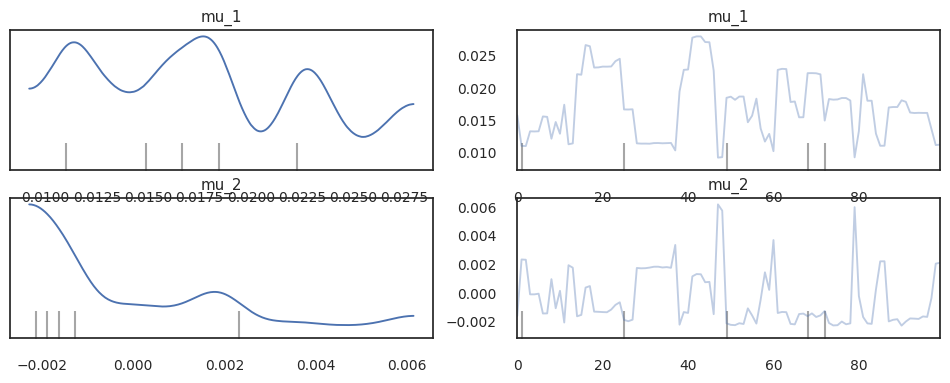

In [48]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model_test, posterior_samples)(y_obs_label)
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
plt.show()

In [49]:
posterior_samples

{'mu_1': tensor([0.0157, 0.0110, 0.0110, 0.0133, 0.0132, 0.0133, 0.0156, 0.0155, 0.0121,
         0.0147, 0.0129, 0.0174, 0.0112, 0.0114, 0.0221, 0.0220, 0.0266, 0.0264,
         0.0231, 0.0232, 0.0233, 0.0233, 0.0233, 0.0241, 0.0245, 0.0166, 0.0166,
         0.0167, 0.0114, 0.0113, 0.0114, 0.0113, 0.0114, 0.0114, 0.0114, 0.0114,
         0.0114, 0.0103, 0.0194, 0.0228, 0.0228, 0.0277, 0.0279, 0.0279, 0.0271,
         0.0270, 0.0226, 0.0092, 0.0092, 0.0184, 0.0186, 0.0181, 0.0186, 0.0186,
         0.0147, 0.0157, 0.0183, 0.0137, 0.0117, 0.0129, 0.0102, 0.0228, 0.0229,
         0.0229, 0.0178, 0.0179, 0.0154, 0.0154, 0.0223, 0.0223, 0.0222, 0.0221,
         0.0149, 0.0182, 0.0182, 0.0182, 0.0184, 0.0184, 0.0180, 0.0092, 0.0133,
         0.0221, 0.0180, 0.0180, 0.0129, 0.0110, 0.0110, 0.0169, 0.0170, 0.0170,
         0.0180, 0.0178, 0.0162, 0.0161, 0.0161, 0.0161, 0.0161, 0.0136, 0.0111,
         0.0112], dtype=torch.float64),
 'mu_2': tensor([-1.6176e-03,  2.3197e-03,  2.3014e-03, -1.12

In [50]:
loc_mean_posterior, loc_cov_posterior =[], []
for key, values in posterior_samples.items():
    print(key)
    if key == "sample_data":
        mean = values.mean(dim=0)
        cov = values.std(dim=0)
        print("mean\n",mean)
        print("cov\n", cov)
        loc_mean_posterior.append(mean.detach().numpy())
        loc_cov_posterior.append(cov.detach().numpy())
    elif key == "sigma_data":
        print("mean\n",values.mean(dim=0), "\nstd\n", values.std(dim=0))
    else:
        print("mean\n",values.mean(), "\nstd\n", values.std())

mu_1
mean
 tensor(0.0171, dtype=torch.float64) 
std
 tensor(0.0050, dtype=torch.float64)
mu_2
mean
 tensor(-0.0004, dtype=torch.float64) 
std
 tensor(0.0020, dtype=torch.float64)


In [416]:
loc_mean_posterior

[]

In [417]:
loc_cov_posterior

[]

In [418]:
# plt.figure(figsize=(8, 6))
# x = np.linspace(-0.5,1.5,8000)
#   # Combine x and y grids into a (100, 100, 2) array
# for i in range(3):
#     # Create a multivariate normal distribution
#     rv = norm(loc_mean_posterior[0][i], loc_cov_posterior[0][i])

#     # Calculate PDF values for each point in the grid
#     pdf_values = rv.pdf(x)

#     # Plot the Gaussian distribution using contour plot
    
#     plt.scatter(x, pdf_values, s=2.5, label='Gaussian_'+str(i+1))
# #plt.colorbar(label='Probability Density')
# plt.xlabel('hsi_spectra')
# plt.ylabel('Unnormalized Probability Density')
# plt.title('Gaussian Distribution')
# #plt.scatter(loc_mean[i], color='red', label='Mean')
# plt.legend()
# plt.grid(True)
# plt.show()

In [51]:
data.posterior

<xarray.Dataset> Size: 2kB
Dimensions:  (chain: 1, draw: 100)
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Data variables:
    mu_1     (chain, draw) float64 800B 0.01572 0.011 ... 0.01112 0.01119
    mu_2     (chain, draw) float64 800B -0.001618 0.00232 ... 0.002028 0.002089
Attributes:
    created_at:                 2024-07-16T18:49:32.769733+00:00
    arviz_version:              0.18.0
    inference_library:          pyro
    inference_library_version:  1.9.0

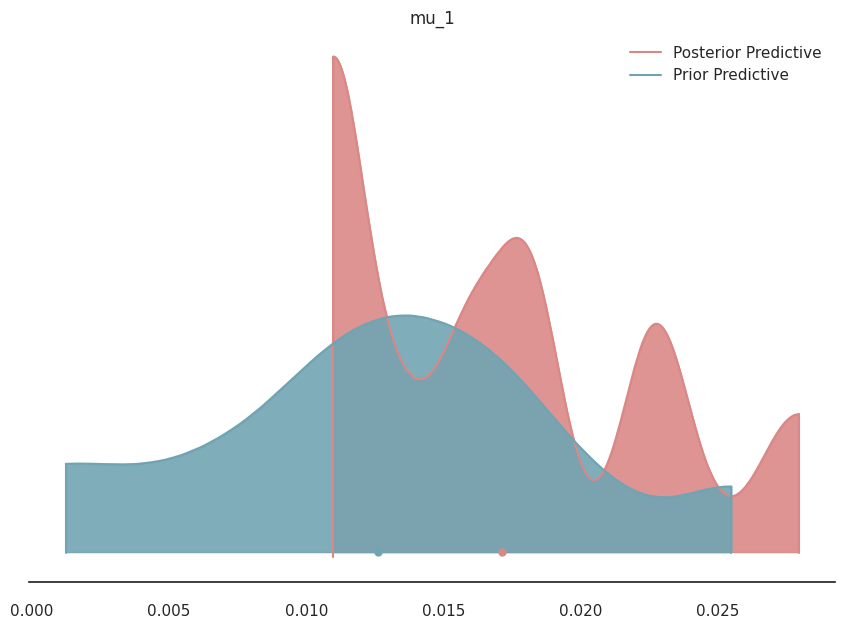

In [52]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_1'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

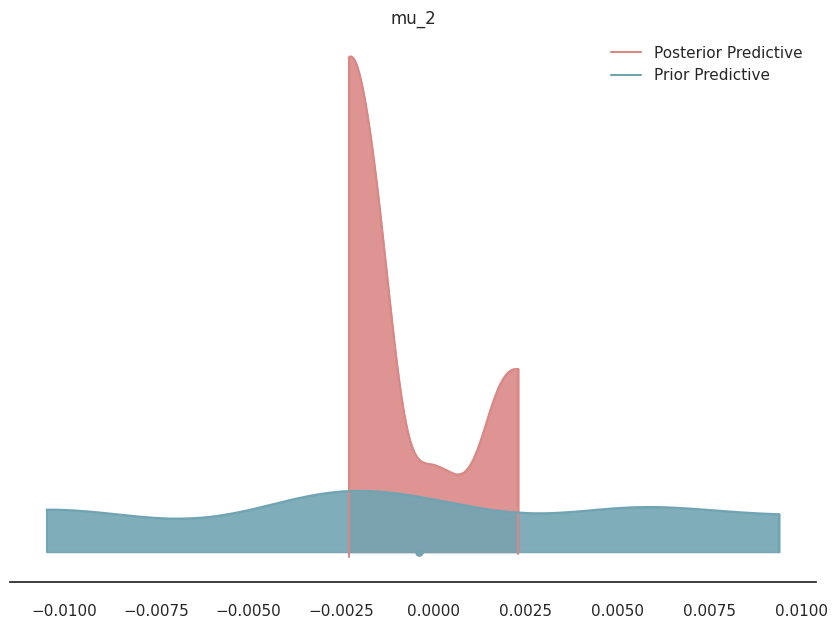

In [53]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_2'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

Condition number: 44062.28719388272.


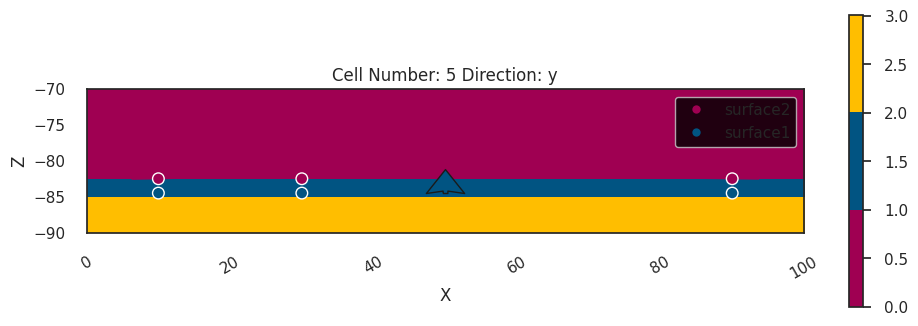

In [54]:
# Update the model with the new top layer's location
interpolation_input = geo_model_test.interpolation_input
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([2]), torch.tensor([2])),
    posterior_samples["mu_1"].mean()
)
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([5]), torch.tensor([2])),
    posterior_samples["mu_2"].mean()
)

#print("interpolation_input",interpolation_input.surface_points.sp_coords)

# # Compute the geological model
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [55]:
sp_coords_copy_test2 =interpolation_input.surface_points.sp_coords
sp_coords_copy_test2

tensor([[-0.2500,  0.0000,  0.0125],
        [ 0.2500,  0.0000,  0.0125],
        [-0.1250,  0.0000,  0.0171],
        [-0.2500,  0.0000,  0.0000],
        [ 0.2500,  0.0000,  0.0000],
        [-0.1250,  0.0000, -0.0004]], dtype=torch.float64,
       grad_fn=<IndexPutBackward0>)

In [56]:
sp_cord= geo_model_test.transform.apply_inverse(sp_coords_copy_test2.detach().numpy())
sp_cord

array([[ 10.        ,   0.        , -82.5       ],
       [ 90.        ,   0.        , -82.5       ],
       [ 30.        ,   0.        , -81.75910422],
       [ 10.        ,   0.        , -84.5       ],
       [ 90.        ,   0.        , -84.5       ],
       [ 30.        ,   0.        , -84.5620366 ]])

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy_engine/core/data/transforms.py:187: RuntimeWarning: Interpolation is being done with the default transform. If you do not know what you are doing you should probably call GeoModel.update_transform() first.
  warnings.warn(


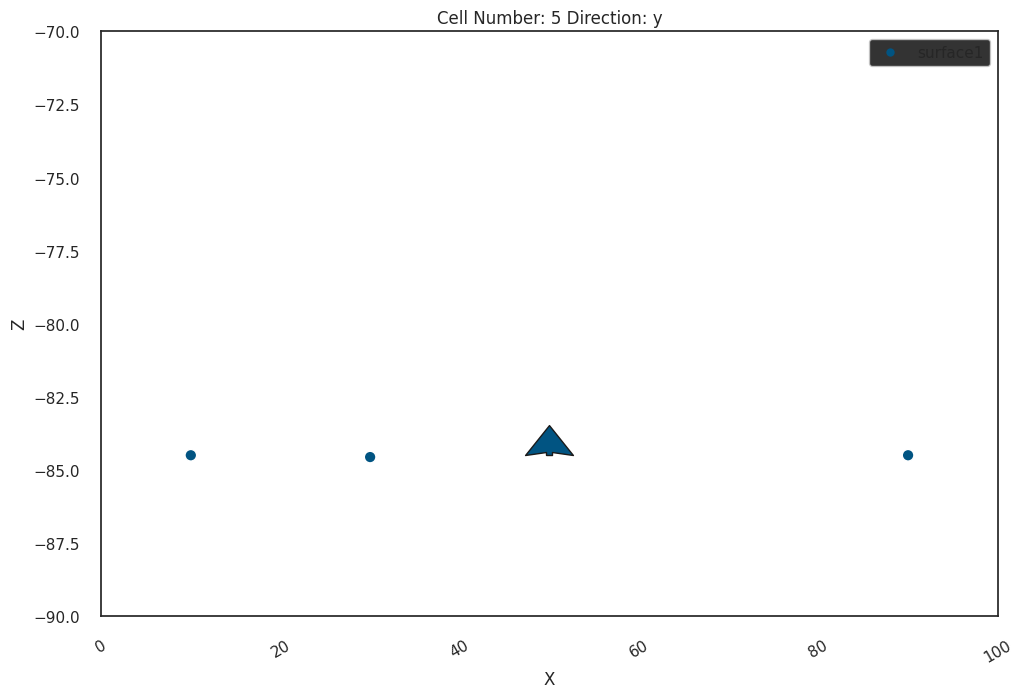

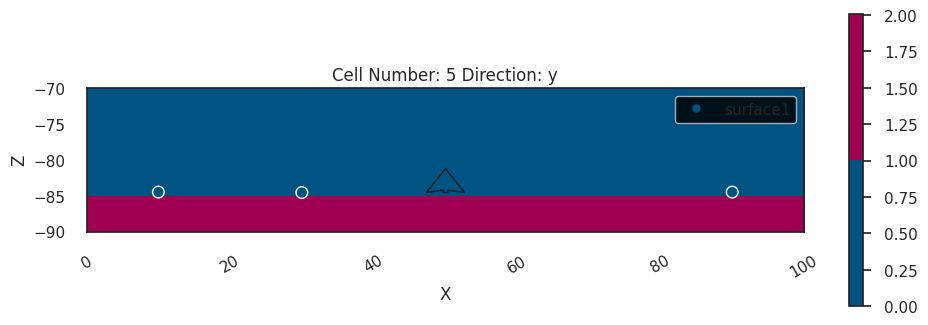

In [119]:
geo_model_post = gp.create_geomodel(
    project_name='Gempy_post_Test',
    extent=[0, 100, -1, 1, -90, -70],
    resolution=[100,10,100],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
geo_model_post.interpolation_options.kernel_options.range=7
gp.add_surface_points(
    geo_model=geo_model_post,
    x=sp_cord[3:,0],
    y=sp_cord[3:,1],
    z=sp_cord[3:,2],
    elements_names=['surface1', 'surface1','surface1']
)
gp.add_orientations(
    geo_model=geo_model_post,
    x=[50],
    y=[0.0],
    z=[brk1],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1.0]]
)
gpv.plot_2d(geo_model_post, cell_number=5, legend='force')
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)  
gp.compute_model(geo_model_post, engine_config=gp.data.GemPyEngineConfig())
gpv.plot_2d(geo_model_post, cell_number=[5])
    

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy_engine/core/data/transforms.py:187: RuntimeWarning: Interpolation is being done with the default transform. If you do not know what you are doing you should probably call GeoModel.update_transform() first.
  warnings.warn(


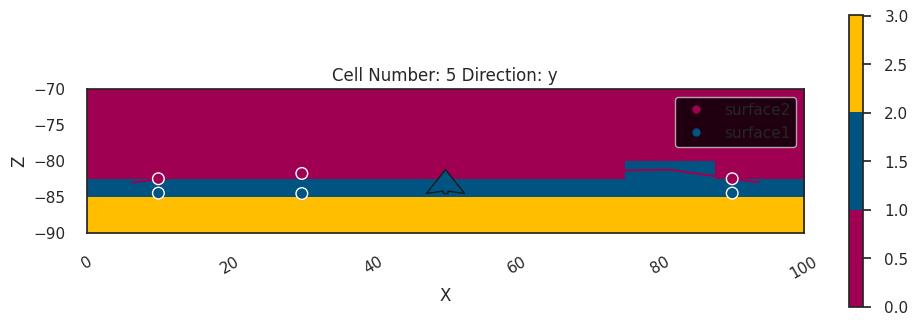

In [120]:
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=sp_cord[0:3,0],
        y=sp_cord[0:3,1],
        z=sp_cord[0:3,2],
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)
geo_model_post.structural_frame.structural_groups[0].append_element(element2)
gp.compute_model(geo_model_post)
#gpv.plot_2d(geo_model_post, cell_number=5, legend='force')
geo_model_post.structural_frame.structural_groups[0].elements[0], geo_model_post.structural_frame.structural_groups[0].elements[1] = \
geo_model_post.structural_frame.structural_groups[0].elements[1], geo_model_post.structural_frame.structural_groups[0].elements[0]
gpv.plot_2d(geo_model_post, cell_number=5, legend='force')


In [121]:
geo_model_post.surface_points

X,Y,Z,id,nugget
10.00,0.00,-82.50,95431086,0.00
90.00,0.00,-82.50,95431086,0.00
30.00,0.00,-81.76,95431086,0.00
10.00,0.00,-84.50,48155407,0.00
90.00,0.00,-84.50,48155407,0.00
30.00,0.00,-84.56,48155407,0.00


In [122]:
# # Creating marginal distribution plots
# p = PlotPosterior(data)
# p.create_figure(figsize=(9, 5), joyplot=False, marginal=True, likelihood=False)
# p.plot_marginal(
#     var_names=['mu_1', 'mu_2'],
#     plot_trace=False,
#     credible_interval=.70,
#     kind='kde',
#     marginal_kwargs={"bw": 1}
# )
# plt.show()

In [123]:
# # Visualizing the posterior distributions
# p = PlotPosterior(data)
# p.create_figure(figsize=(9, 6), joyplot=True)
# iteration = 99
# p.plot_posterior(
#     prior_var=['mu_1', 'mu_2'],
#     like_var=['mu_1', 'mu_2'],
#     obs='obs',
#     iteration=iteration,
#     marginal_kwargs={
#         "credible_interval": 0.94,
#         'marginal_kwargs': {"bw": 1},
#         'joint_kwargs': {"bw": 1}
#     }
# )
# plt.show()

In [124]:
# # Creating a pair plot for selected parameters
# az.plot_pair(data, divergences=False, var_names=['mu_1', 'mu_2'])
# plt.show()